In [46]:
import os
import random
import shutil
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from PIL import Image
import pillow_heif

import torch
import torchvision.transforms.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.model_selection import StratifiedShuffleSplit

# Enable HEIF/HEIC support
pillow_heif.register_heif_opener()

# <center>Prepare the Data for the “others” Class</center>

- The majority of images in the “others” class are sourced from the [PlantNet-300K dataset](https://www.kaggle.com/datasets/noahbadoa/plantnet-300k-images).
- A random selection of images for this class is made exclusively from the images_val set.
- Additionally, 31 images in the “others” class were personally photographed by me.

In [3]:
def copy_random_images(base_path, dest_path, num_images):
    """
    Copies a random selection of images from subfolders in base_path to dest_path.
    
    Args:
        base_path (str): Path to the folder containing subfolders of images.
        dest_path (str): Destination path where selected images will be copied.
        num_images (int): Number of images to copy randomly.
    """
    # Ensure the destination directory exists
    os.makedirs(dest_path, exist_ok=True)

    # Get all subfolders (species folders)
    species_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    # Gather all image paths
    all_images = []
    for folder in species_folders:
        images = [os.path.join(folder, img) for img in os.listdir(folder) if os.path.isfile(os.path.join(folder, img))]
        all_images.extend(images)

    # Randomly select the specified number of images
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Copy selected images to the destination folder
    for img_path in selected_images:
        shutil.copy(img_path, os.path.join(dest_path, os.path.basename(img_path)))

    print(f"Copied {len(selected_images)} images to {dest_path}.")

In [4]:
base_path = '/Users/drmorsy/Downloads/PlantNet/images_val'
dest_path = '/Users/drmorsy/Downloads/Wadi Degla/Plants/others/PlantNet'
num_images = 500
copy_random_images(base_path, dest_path, num_images)

Copied 500 images to /Users/drmorsy/Downloads/Wadi Degla/Plants/others/PlantNet.


# <center>Preprocessing Images for ImageFolder Compatibility</center>

In [89]:
# Supported formats for ImageFolder
SUPPORTED_FORMATS = {".jpg", ".jpeg", ".png"}

def convert_images(root_dir, output_format="jpeg", delete_original=False):
    """
    Converts all images in root_dir to a format compatible with datasets.ImageFolder.
    
    Args:
        root_dir (str): Path to the dataset directory.
        output_format (str): Target format ('jpeg' or 'png').
        delete_original (bool): If True, deletes the original image after conversion.
    """
    counter = 0
    for subdir, _, files in os.walk(root_dir):
        
        for file in files:
            file_path = os.path.join(subdir, file)
            file_ext = os.path.splitext(file)[1].lower()
            
            # Skip already supported formats
            if file_ext in SUPPORTED_FORMATS:
                continue
            
            try:
                counter+=1
                # Open and convert image
                img = Image.open(file_path).convert("RGB")
                new_file = os.path.splitext(file_path)[0] + f".{output_format}"
                
                # Save as new format
                img.save(new_file, format=output_format.upper())
                
                # Delete original file if enabled
                if delete_original:
                    os.remove(file_path)
                    if counter % 100 ==0:
                        print(f"Converted and deleted{counter}: {file_path} → {new_file}")
                else:
                    if counter % 100 ==0:
                        print(f"Converted{counter}: {file_path} → {new_file}")
            
            except Exception as e:
                pass

# Set dataset directory path
data_dir = "/Users/drmorsy/Downloads/Wadi Degla/Plants"

# Convert all images to JPEG
convert_images(data_dir, output_format="jpeg", delete_original=True)

# <center>Dataset Loading and Stratified Train-Test Split.</center>

## 1. Loading the Dataset
- Load dataset using ImageFolder and display basic statistics.

In [7]:
# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root='/Users/drmorsy/Downloads/Wadi Degla/Plants')
print(f'Number of plant species: {len(dataset.classes)}')
print(f'Number of images: {len(dataset.targets)}')

Number of plant species: 34
Number of images: 21901


## 2. Stratified Train-Test Split

- The image dataset is shuffled and split into training and testing sets using `StratifiedShuffleSplit`, ensuring that the class distribution remains the same as in the original dataset.
- The dataset is divided into 80% for training and 20% for testing.
- The `Subset` utility class from torch.utils.data is used to create smaller datasets by selecting specific indices from the original dataset, allowing efficient handling of the split.

In [8]:
# Get the class labels for stratification
targets = np.array(dataset.targets)  # Targets correspond to class indices

# Define stratified split (80% train, 20% test)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Generate train/test indices
for train_idx, test_idx in stratified_split.split(np.empty(len(targets))#
                                                  , targets):
    
    train_indices = train_idx # The indices of images assigned to the training set.
    test_indices = test_idx # The indices of images assigned to the test sets.

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# <center>Exploratory Data Analysis (EDA) of Image Dataset Distribution</center>

## 1. Probability Density Function (PDF) of Image Dataset Distribution
- Visualizing the distribution of images per species using a kernel density estimate (KDE) plot.

In [9]:
def plot_pdf_image_distribution(dataset, dataset_type="Whole"):
    """
    Plots the probability density function (PDF) of image distribution in a dataset.

    Parameters:
        dataset: PyTorch ImageFolder dataset or Subset.
        dataset_type: str, optional (default="Whole")
            The type of dataset ("Whole", "Train", or "Test").
    """

    # Handle Subset datasets
    if isinstance(dataset, torch.utils.data.Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        targets = dataset.targets

    # Count the number of images per species
    class_counts = Counter(targets)
    image_counts = np.array(list(class_counts.values()))

    # Compute total species and total images
    total_species = len(class_counts)
    total_images = image_counts.sum()

    # Plot the KDE (Probability Density Function)
    plt.figure(figsize=(10, 6))
    ax = sns.kdeplot(image_counts, fill=True, color='skyblue', alpha=0.7)

    # Labels and title
    plt.xlabel("Number of Images per Species")
    plt.ylabel("Density")
    plt.title(f'Probability Density Function of Image Distribution in the {dataset_type} Dataset')
    plt.grid(True, linestyle="--", alpha=0.6)

    # Get the y-axis limit to position the text
    y_min, y_max = plt.ylim()
    y_start_last_third = y_min + (2 / 3) * (y_max - y_min)  # Start of the last one-third

    # Add total species and images as text
    plt.text(image_counts.max() * 0.7, y_start_last_third, 
             f"Total Species: {total_species}\nTotal Images: {total_images}", 
             fontsize=12, color="black", verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

    plt.show()

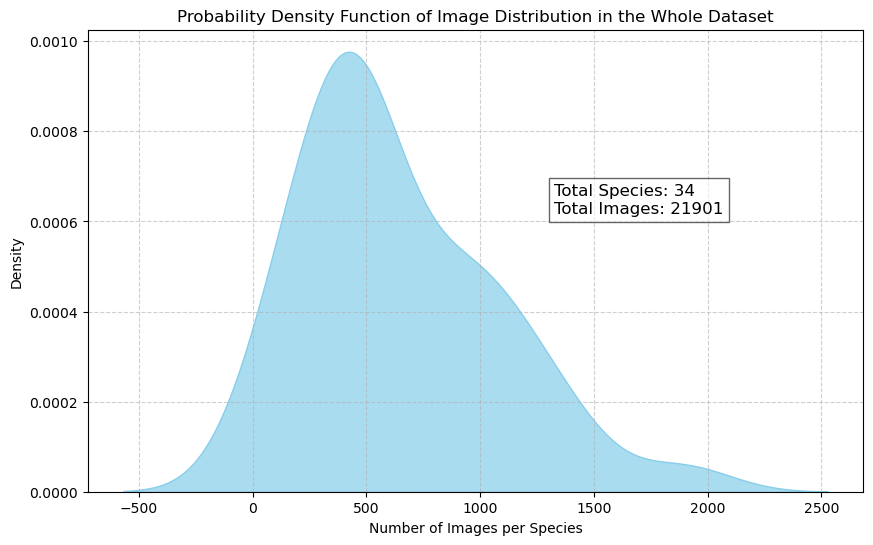

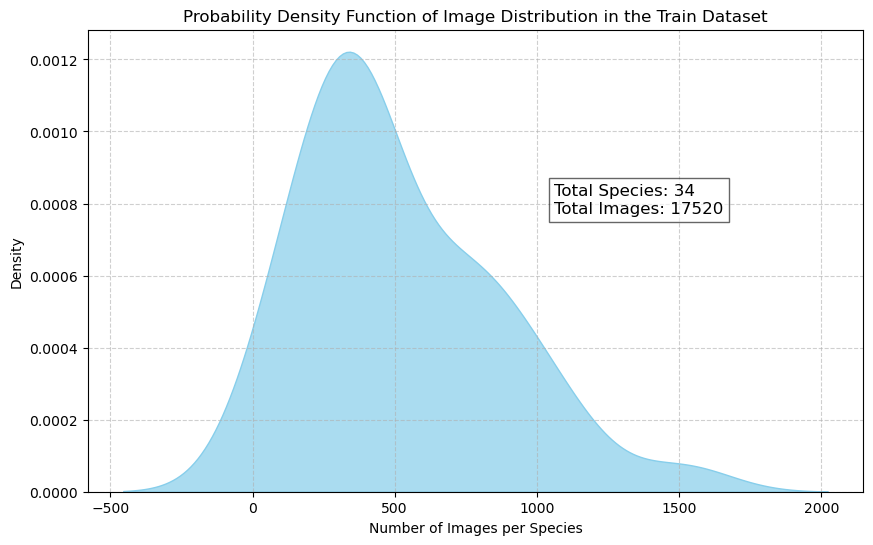

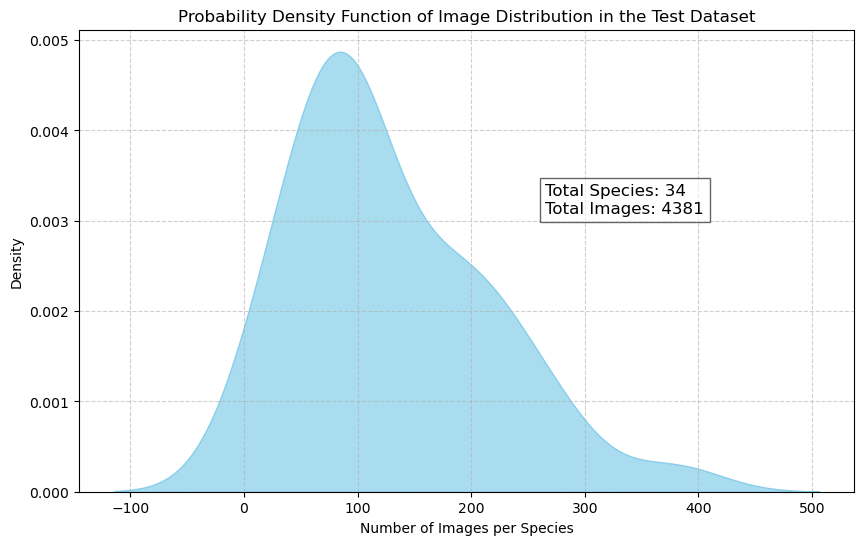

In [10]:
plot_pdf_image_distribution(dataset, dataset_type="Whole")
plot_pdf_image_distribution(train_dataset, dataset_type="Train")
plot_pdf_image_distribution(test_dataset, dataset_type="Test")

## 2. Species-wise Image Dataset Count Distribution
- Displaying the number of images per species in ascending order using a bar plot.

In [11]:
def plot_species_image_counts(dataset, dataset_type="Whole", 
                              figsize=(15, 10), x_interval=500):
    """
    Plots the number of images per species in ascending order.

    Args:
        dataset: PyTorch ImageFolder dataset or Subset.
        dataset_type: String indicating the type of dataset ("Whole", "Train", "Test").
        figsize: Tuple specifying the figure size (width, height).
        x_interval: Interval for the x-axis ticks.
    """
    # Handle Subset datasets
    if isinstance(dataset, torch.utils.data.Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        classes = dataset.dataset.classes
    else:
        targets = dataset.targets
        classes = dataset.classes

    # Count the number of images per species
    class_counts = Counter(targets)

    # Sort by number of images (ascending order)
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[1])
    species_names = [classes[idx] for idx, _ in sorted_counts]
    image_counts = np.array([count for _, count in sorted_counts])

    # Compute total species and total images
    total_species = len(species_names)
    total_images = image_counts.sum()

    # Compute proportions
    proportions = (image_counts / total_images) * 100

    # Plot the data
    plt.figure(figsize=figsize)
    bars = plt.barh(species_names, image_counts, color='skyblue')

    # Annotate each bar with its proportion
    for bar, proportion in zip(bars, proportions):
        plt.text(bar.get_width() + max(image_counts) * 0.01, 
                 bar.get_y() + bar.get_height() / 2, 
                 f"{proportion:.1f}%", 
                 va='center', fontsize=10, color='black')

    # Labels and title
    plt.xlabel("Number of Images")
    plt.ylabel("Species")
    plt.title(f"Number of Images per Species in the {dataset_type} Dataset (Ascending Order)")
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Adjust x-axis intervals
    max_x = max(image_counts)
    plt.xticks(np.arange(0, max_x + x_interval, x_interval))

    # Position the text at the start of the last one-third of the y-axis range
    y_start_last_third = total_species * (2 / 3)  # Start of last one-third
    text_y_pos = species_names[int(y_start_last_third)]  # Get the corresponding species name

    # Add total species and images as text
    plt.text(max_x * 0.6, y_start_last_third, 
             f"Total Species: {total_species}\nTotal Images: {total_images}", 
             fontsize=12, color="black", verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))

    plt.show()

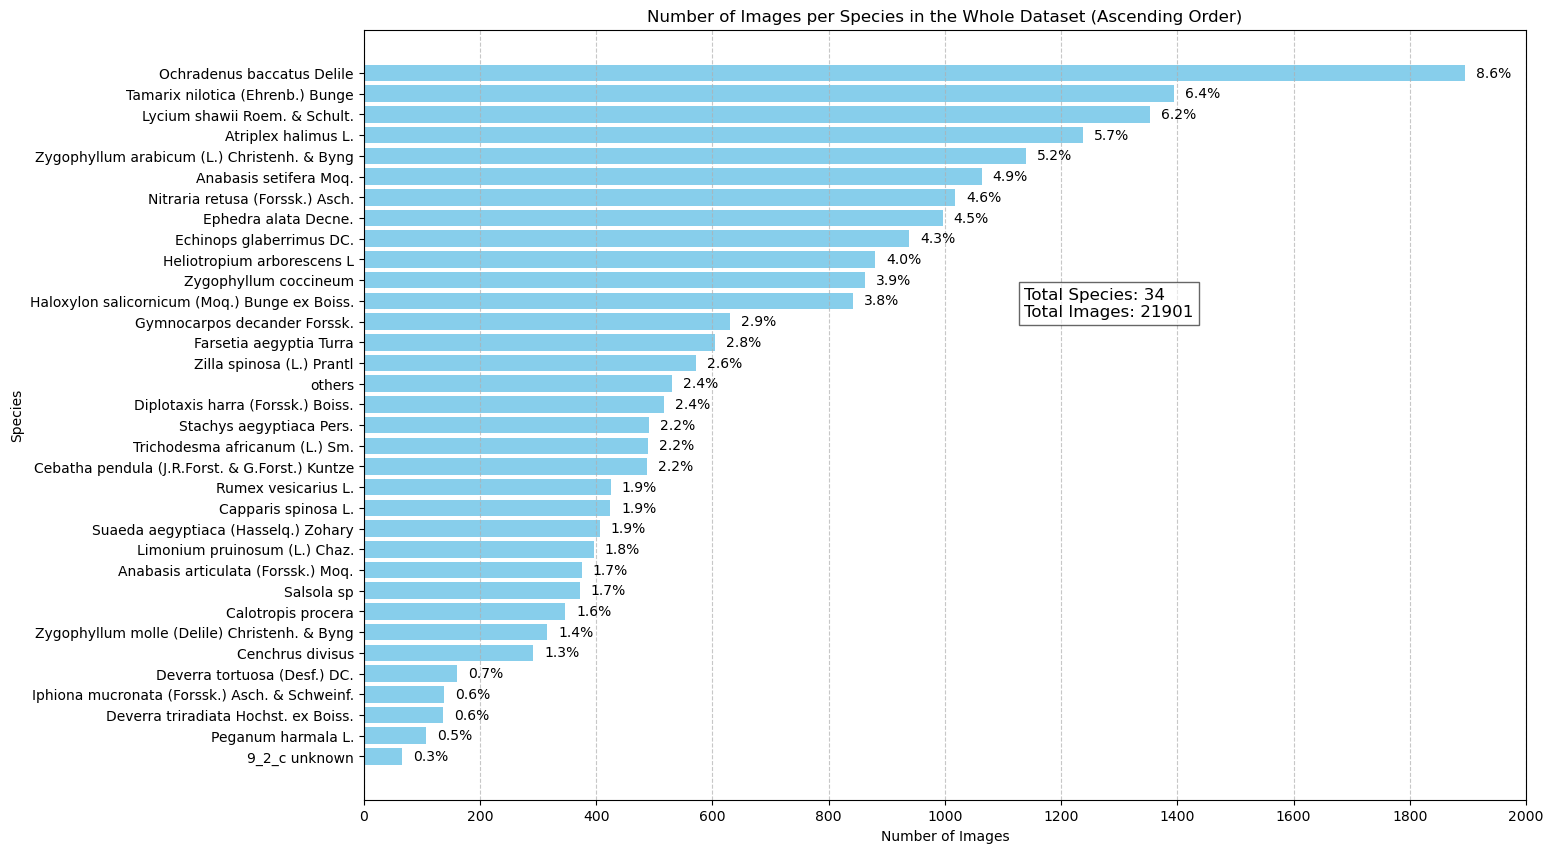

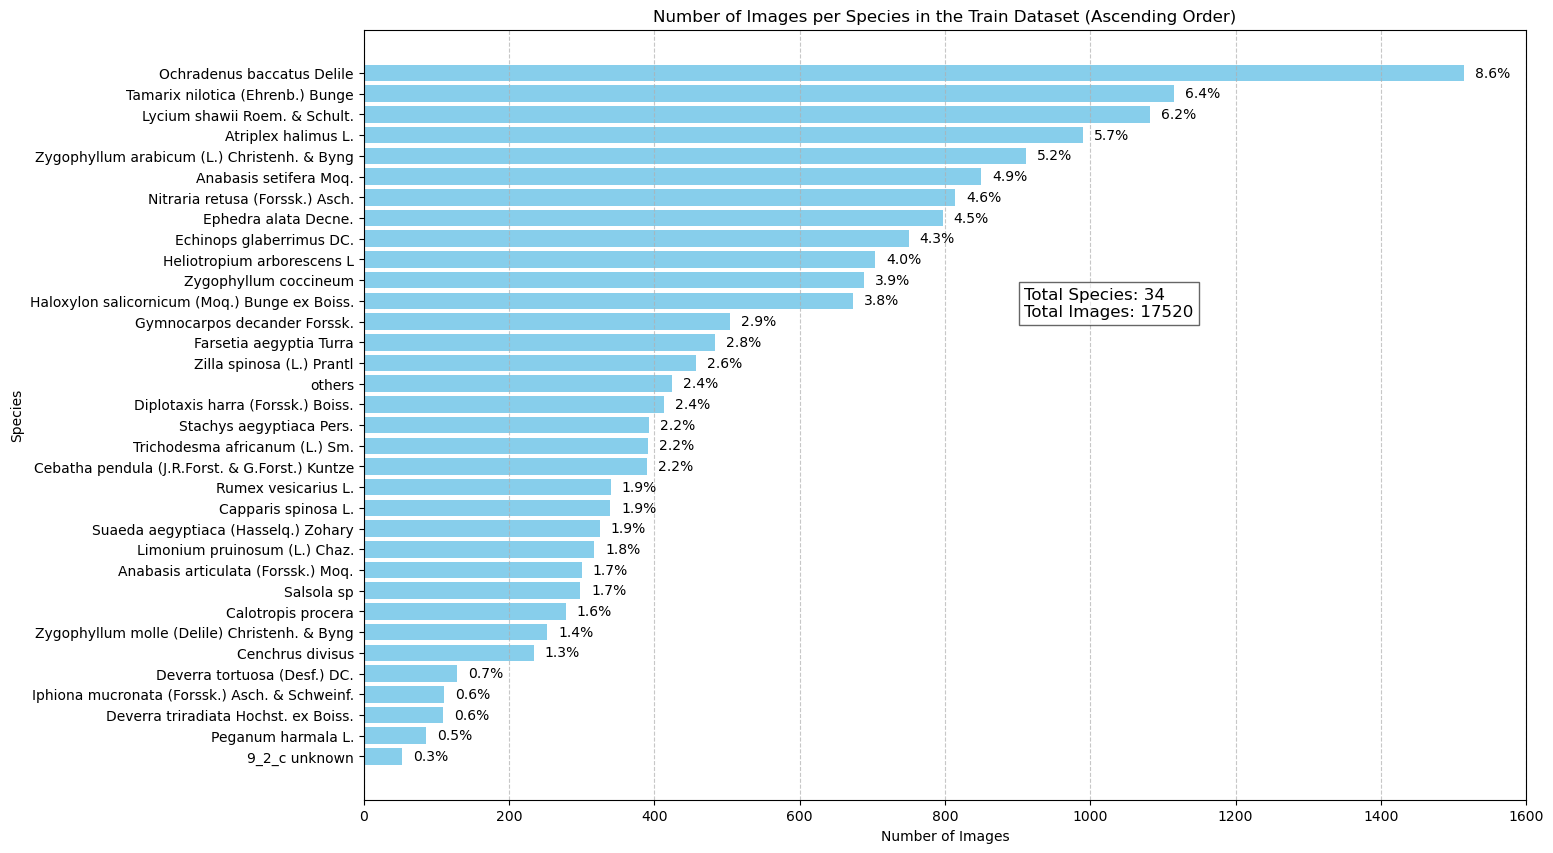

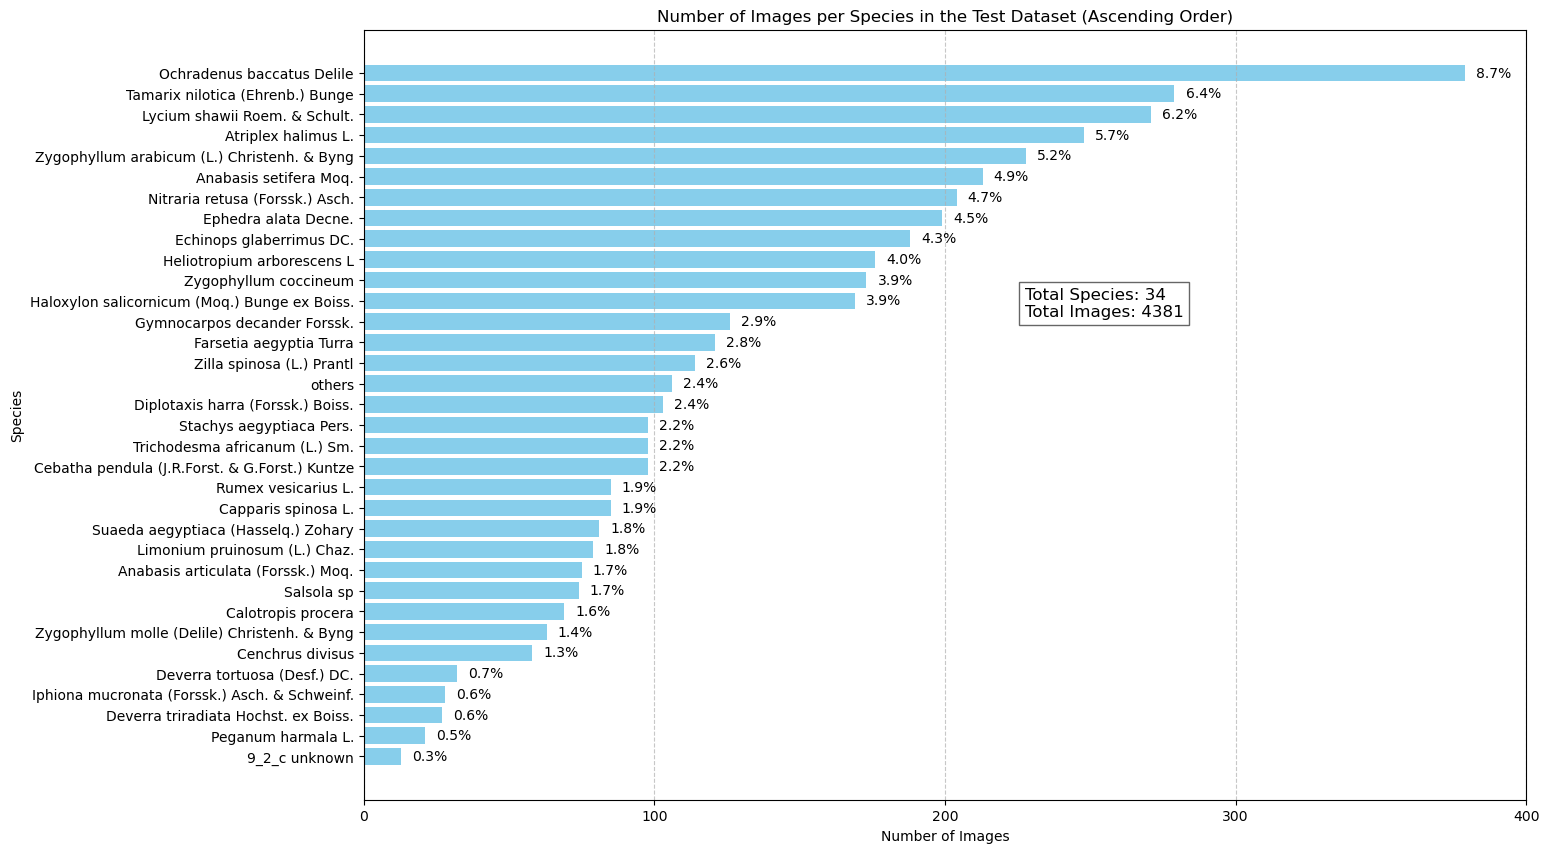

In [12]:
plot_species_image_counts(dataset, dataset_type="Whole", x_interval=200)
plot_species_image_counts(train_dataset, dataset_type="Train", x_interval=200)
plot_species_image_counts(test_dataset, dataset_type="Test", x_interval=100)

## 3. Box Plot Analysis of Image Dataset Distribution
- Using a box plot to highlight distribution patterns, central tendencies, and outliers in image counts per species.

In [13]:
def plot_boxplot_image_distribution(dataset, dataset_type="Whole"):
    """
    Plots the distribution of image counts per species using a box plot,
    highlighting outliers, mean, and median.

    Parameters:
        dataset: PyTorch ImageFolder dataset or Subset.
        dataset_type: str, optional (default="Whole")
            The type of dataset ("Whole", "Train", or "Test").
    """

    # Handle Subset datasets
    if isinstance(dataset, torch.utils.data.Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        classes = dataset.dataset.classes
    else:
        targets = dataset.targets
        classes = dataset.classes

    # Count the number of images per species
    class_counts = Counter(targets)
    image_counts = np.array(list(class_counts.values()))

    # Compute statistics
    mean_count = np.mean(image_counts)
    median_count = np.median(image_counts)
    q1 = np.percentile(image_counts, 25)
    q3 = np.percentile(image_counts, 75)
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = {classes[idx]: count for idx, count in class_counts.items() 
                if count < lower_bound or count > upper_bound}

    # Create the box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=image_counts, color="skyblue")

    # Plot mean and median as horizontal lines
    plt.axhline(mean_count, color="red", linestyle="--", label=f"Mean: {mean_count:.2f}")
    plt.axhline(median_count, color="green", linestyle="-.", label=f"Median: {median_count:.2f}")

    # Annotate outliers
    for species, count in outliers.items():
        plt.text(0.02, count, species, ha='left', va='center', fontsize=10, color="black")

    # Customize plot
    plt.ylabel("Number of Images per Species")
    plt.title(f"Distribution of Image Counts per Species in the {dataset_type} Dataset")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.show()

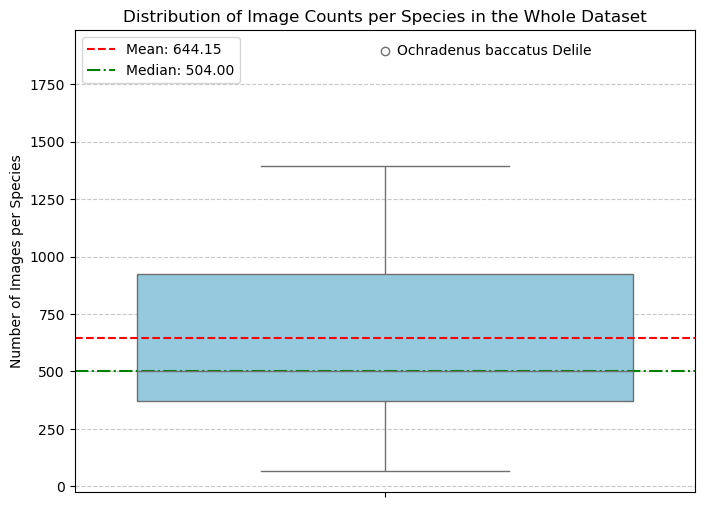

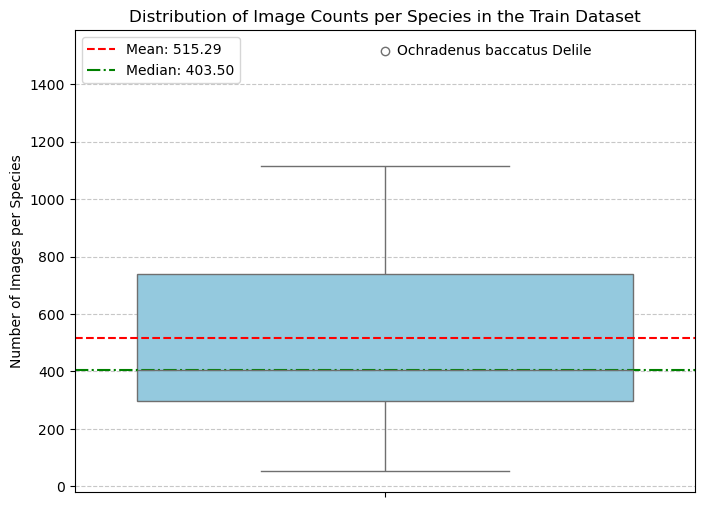

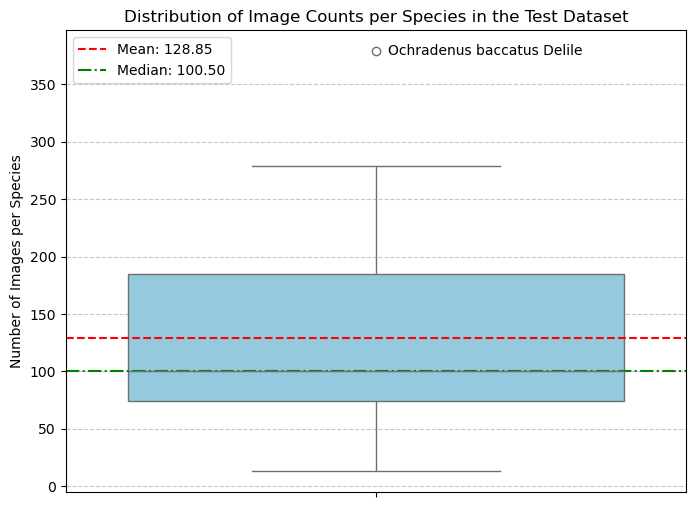

In [14]:
plot_boxplot_image_distribution(dataset, dataset_type="Whole")
plot_boxplot_image_distribution(train_dataset, dataset_type="Train")
plot_boxplot_image_distribution(test_dataset, dataset_type="Test")

## Conclusion

**The distribution of images across species in the original dataset is preserved in both the training and test sets. This confirms that stratified sampling was applied, ensuring that each species is proportionally represented in both subsets.**

# <center>Define the Transformation Pipeline</center>

## Preprocessing techniques

1. Rescaling to 224 x 224 dimensions.
2. Apply normalization to the images in the dataset, scaling pixel values to the range of -1 to 1.

## Data augmentation

- The purpose of data augmentation techniques is to enhance the model’s capacity by introducing greater variability into the dataset. At each epoch, the model encounters the same image in different variations, effectively increasing the dataset size and improving generalization.
- The augmentation techniques are applied only to the training dataset, as for testing, we need the model to evaluate images in their original form to ensure a fair assessment of its performance on unseen data.

**Important warning**
- The augmented image should still depicts the same object
- If you apply a color shift augmentation to an image of the lemon. The augmented image will still be labeled as lemon, but in fact, it will look more like a lime.
- If we apply the vertical flip to the letter "W" it will look like the letter "M".
- Sometimes, specific augmentations can impact the label. It's important to notice that an augmentation could be confusing depending on the task. We could apply the vertical flip to the lemon or the color shift to the letter "W" without introducing noise in the labels. Remember to always choose augmentations with the data and task in mind!
- For test data, we need to define separate transforms without data augmentation! We only keep parsing to tensor and resizing. `This is because we want the model to predict a specific test image, not a random transformation of it.`

**1. Random rotation:**
- `transforms.RandomRotation(degrees=(-90, 90))`
    - This applies a random rotation to an image.
    - The rotation angle is randomly sampled from the range of -90 to 90 degrees.
    - Each image will be rotated by a different angle within this range, introducing variability.

- `interpolation=transforms.InterpolationMode.BILINEAR`
    - Specifies the interpolation method used for filling pixel values after rotation.
    - Bilinear interpolation:
        - The new pixel values are computed as a weighted average of the four nearest pixels.

**2. Random brightness change**
- `transforms.ColorJitter(brightness=0.2)`
    - This randomly adjusts the brightness of the image.
    - The brightness factor is sampled from the range [1 - 0.2, 1 + 0.2] = [0.8, 1.2].
    - Each pixel value in the image is scaled by a randomly chosen factor within this range.

- Effect of This Transformation:
    - If the factor is 0.8, the image becomes darker (pixel values decrease by up to 20%).
    - If the factor is 1.2, the image becomes brighter (pixel values increase by up to 20%).
    - This improves generalization by simulating different lighting conditions.

**3. Horizontal flip**
- `transforms.RandomHorizontalFlip(p=0.5)`
    - This randomly flips the image horizontally (left to right).
    - The flipping occurs with a probability of 50% (p=0.5).

- `Effect of This Transformation`
    - If applied, the left side of the image swaps with the right side.
    - This helps the model become invariant to horizontal orientation changes.
    - It’s useful for natural images where left-right symmetry doesn’t change the meaning (e.g., plant species, animals, or objects).

**4. Data Augmentation Wrapping**
- Wrap all augmentation techniques in transforms.RandomApply with p=0.8.
- In each epoch, 20% of images remain unaltered.
- Over 10 epochs, the model trains on the original dataset without changes at least twice.
- This approach introduces variation while ensuring exposure to original data.
- Benefit: Balances augmentation with original data, enhancing generalization.

In [15]:
# Define the transformation pipeline for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomRotation(degrees=(-90, 90), interpolation=transforms.InterpolationMode.BILINEAR), # Ensure angles are sampled over multiple batches
        transforms.ColorJitter(brightness=0.2),  # Random brightness change in range [-0.2, 0.2]
        transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip
    ], p=0.8),
    transforms.Resize((224, 224)),  # Rescale to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale pixel values to [-1,1]
])

# Define the transformation pipeline for validation/testing (without augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Rescale to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale pixel values to [-1,1]
])

## Visaulizaion

### Apply transforms for training

In [16]:
dataset.transform = train_transforms  # Augmentation for training

In [17]:
train_dataset.dataset.transform

Compose(
    RandomApply(
    p=0.8
    RandomRotation(degrees=[-90.0, 90.0], interpolation=bilinear, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    RandomHorizontalFlip(p=0.5)
)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [18]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Function to show images
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor to NumPy
    img = img * 0.5 + 0.5  # Unnormalize (assuming mean=0.5, std=0.5)
    img = np.clip(img, 0, 1)  # Clip values to valid range
    
    plt.imshow(img)
    plt.title(title, fontsize=12, fontweight="bold")
    plt.axis("off")

# Function to visualize a batch of images with labels
def visualize_batch(dataloader, dataset, num_images=6):
    images, labels = next(iter(dataloader))  # Get a batch
    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)  # Create a grid of subplots
        imshow(images[i], dataset.classes[labels[i].item()])
    
    plt.tight_layout()
    plt.show()

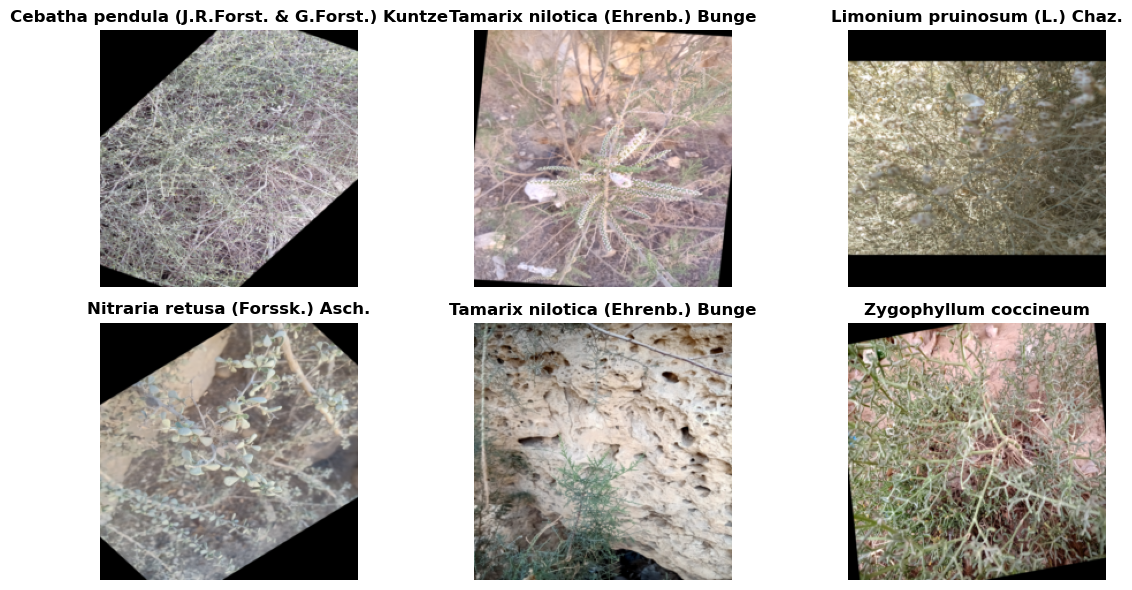

In [20]:
visualize_batch(train_loader, dataset, num_images=6)

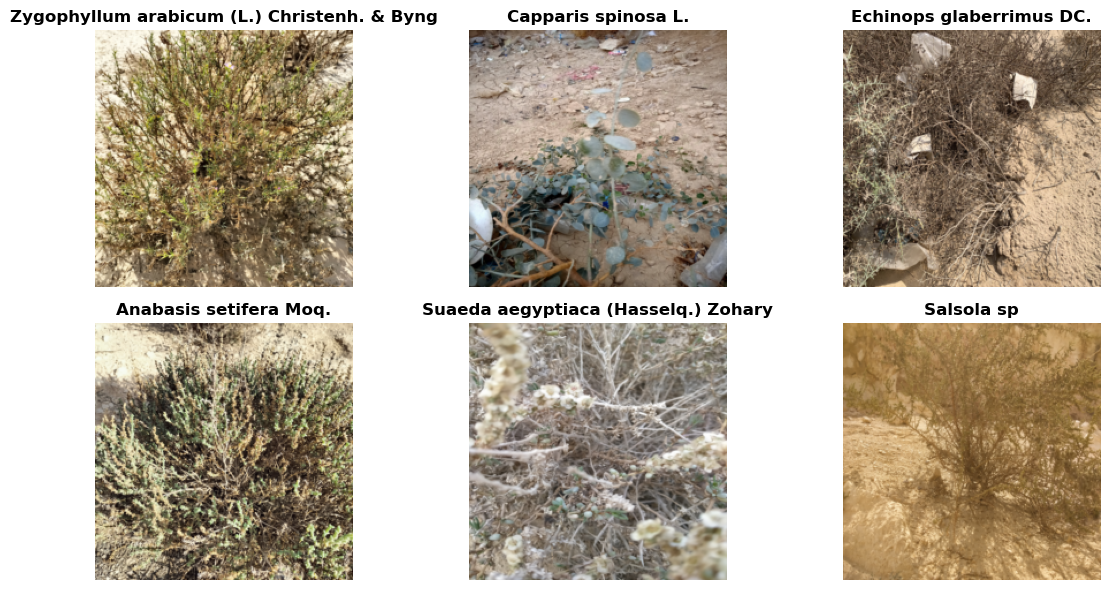

In [21]:
dataset.transform = test_transforms  # No augmentation for testing
visualize_batch(test_loader, dataset, num_images=6)

# 	<center>General Functionality</center>

## 1. compute_class_weights

In [22]:
def compute_class_weights(dataset, method="inverse_frequency"):
    """
    Compute class weights based on the chosen method.

    Args:
        dataset: A dataset object with a 'targets' attribute containing class labels.
        method (str): Method for computing class weights. Options:
            - "inverse_frequency": total_samples / count
            - "balanced": total_samples / (count * num_classes)
            - "sqrt_inverse": 1 / np.sqrt(count)
            - "scaled_sqrt_inverse": (1 / np.sqrt(count)) * 100

    Returns:
        torch.Tensor: Class weights tensor on the appropriate device.
    """
    # Compute class frequencies
    class_counts = Counter(dataset.targets)
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    # Select weight calculation method
    if method == "inverse_frequency":
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    elif method == "balanced":
        class_weights = {cls: total_samples / (count * num_classes) for cls, count in class_counts.items()}
    elif method == "sqrt_inverse":
        class_weights = {cls: 1 / np.sqrt(count) for cls, count in class_counts.items()}
    elif method == "scaled_sqrt_inverse":
        class_weights = {cls: (1 / np.sqrt(count)) * 100 for cls, count in class_counts.items()}
    else:
        raise ValueError("Invalid method. Choose from 'inverse_frequency', 'balanced', 'sqrt_inverse', 'scaled_sqrt_inverse'.")

    # Convert to tensor
    class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

    # Move weights to MPS (Apple GPU) if available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    return class_weights_tensor.to(device)

## 2. load_mobilenet_v2

In [23]:
def load_mobilenet_v2(dataset, num_unfreeze=20, device=None):
    """
    Load a pretrained MobileNetV2 model, freeze layers except the last `num_unfreeze` layers,
    and replace the classifier for a custom number of classes.

    Args:
        dataset: Dataset object with a 'classes' attribute to determine the number of output classes.
        num_unfreeze (int): Number of layers to keep trainable from the end.
        device (torch.device, optional): Device to move the model to (defaults to MPS or CPU).

    Returns:
        nn.Module: Modified MobileNetV2 model.
    """
    # Set device if not provided
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # Load pretrained MobileNetV2
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

    # Freeze all layers except the last `num_unfreeze` trainable layers
    for param in list(model.features.parameters())[:-num_unfreeze]:
        param.requires_grad = False

    # Replace classifier to match dataset classes
    num_classes = len(dataset.classes)
    model.classifier = nn.Sequential(
        nn.Linear(model.last_channel, num_classes)
    )

    # Move model to the specified device
    return model.to(device)

## 3. train_model

In [48]:
def train_model(model, train_loader, criterion, optimizer, class_names, num_epochs=1):
    start_time = time.time()  # Start tracking time
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")  # Use GPU if available on Mac

    # Dictionary to store per-class metrics
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Store predictions for per-class metrics
            for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = (time.time() - start_time)/60
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}m")

        epoch_time = (time.time() - epoch_start_time)/60
        print(f"Epoch {epoch+1} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}m")
        overall_accuracy = accuracy

    total_time = (time.time() - start_time)/60
    print(f"Training Complete - Total Time: {total_time:.2f}m")

    # Calculate per-class accuracy, precision, recall, and F1-score
    all_y_true = []
    all_y_pred = []
    
    for class_idx in sorted(class_metrics.keys()):
        all_y_true.extend(class_metrics[class_idx]["y_true"])
        all_y_pred.extend(class_metrics[class_idx]["y_pred"])
    
    # Compute per-class precision, recall, and F1-score
    unique_classes = sorted(set(all_y_true))  # Get all unique classes
    per_class_metrics = {
        "precision": precision_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0),
        "recall": recall_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0),
        "f1_score": f1_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0)
    }

    # Store per-class results in alignment with unique_classes
    class_results = []
    for class_idx in unique_classes:
        accuracy = 100 * class_metrics[class_idx]["correct"] / class_metrics[class_idx]["total"]
        class_results.append([
            class_names[class_idx],
            accuracy,
            per_class_metrics["precision"][unique_classes.index(class_idx)],
            per_class_metrics["recall"][unique_classes.index(class_idx)],
            per_class_metrics["f1_score"][unique_classes.index(class_idx)]
        ])

    # Create a DataFrame with per-class accuracy, precision, recall, and F1-score
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)", "Precision", "Recall", "F1-score"])

    # Append overall metrics (Macro) as the last row
    macro_accuracy = df_results['Accuracy (%)'].mean()
    macro_precision = per_class_metrics["precision"].mean()
    macro_recall = per_class_metrics["recall"].mean()
    macro_f1 = per_class_metrics["f1_score"].mean()

    df_results.loc[len(df_results)] = ["Average Performance (Macro)", macro_accuracy, macro_precision, macro_recall, macro_f1]
    
    return df_results, overall_accuracy, running_loss, epoch_time

## 4. evaluate_model

In [57]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    
    start_time = time.time()  # Track evaluation time

    # Dictionary to store per-class metrics
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})
    all_y_true = []
    all_y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_y_true.extend(labels.cpu().numpy())
            all_y_pred.extend(preds.cpu().numpy())

            # Compute accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Store per-class metrics
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = (time.time() - start_time)/60
                print(f"Batch {batch_idx}, Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}m")

    total_time = (time.time() - start_time)/60
    print(f"Evaluation Complete - Accuracy: {accuracy:.2f}%, Total Time: {total_time:.2f}m")
    overall_accuracy = accuracy

    # Compute per-class accuracy
    class_results = []
    for class_idx in sorted(class_metrics.keys()):
        metrics = class_metrics[class_idx]
        accuracy = 100 * metrics["correct"] / metrics["total"]
        class_results.append([class_names[class_idx], accuracy])

    # Compute per-class precision, recall, and F1-score
    unique_classes = sorted(set(all_y_true))  # Get all unique classes
    per_class_metrics = {
        "precision": precision_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0),
        "recall": recall_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0),
        "f1_score": f1_score(all_y_true, all_y_pred, labels=unique_classes, average=None, zero_division=0)
    }

    # Store per-class metrics
    for idx, class_label in enumerate(unique_classes):
        class_results[idx].extend([
            per_class_metrics["precision"][idx],
            per_class_metrics["recall"][idx],
            per_class_metrics["f1_score"][idx]
        ])

    # Create a DataFrame with per-class accuracy, precision, recall, and F1-score
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)", "Precision", "Recall", "F1-score"])

    # Append overall metrics (Macro) as the last row
    macro_accuracy = df_results['Accuracy (%)'].mean()
    macro_precision = per_class_metrics["precision"].mean()
    macro_recall = per_class_metrics["recall"].mean()
    macro_f1 = per_class_metrics["f1_score"].mean()

    df_results.loc[len(df_results)] = ["Average Performance (Macro)", macro_accuracy, macro_precision, macro_recall, macro_f1]
    
    return df_results, overall_accuracy, total_time

## 5. create_performance_summary

In [82]:
def create_performance_summary(df, micro_accuracy, total_loss, data_loader, model_name, train_test, class_weights, time_taken):
    # Extract macro metrics from the last row
    macro_row = df[df['Species'] == 'Average Performance (Macro)']
    accuracy_macro = macro_row['Accuracy (%)'].values[0]
    precision_macro = macro_row['Precision'].values[0]
    recall_macro = macro_row['Recall'].values[0]
    f1_macro = macro_row['F1-score'].values[0]


    # Compute loss per epoch
    if total_loss is not None:
        loss = total_loss / len(data_loader)
    else:
        loss = total_loss

    # Exclude the last row to analyze per-class accuracies
    class_accuracies = df[df['Species'] != 'Average Performance (Macro)'].copy()

    # Identify best and worst class based on accuracy
    best_class = class_accuracies.loc[class_accuracies['Accuracy (%)'].idxmax(), 'Species']
    worst_class = class_accuracies.loc[class_accuracies['Accuracy (%)'].idxmin(), 'Species']

    # Compute the median accuracy and find the nearest class
    median_accuracy = class_accuracies['Accuracy (%)'].median()
    class_accuracies['Abs_Diff'] = (class_accuracies['Accuracy (%)'] - median_accuracy).abs()
    median_class = class_accuracies.loc[class_accuracies['Abs_Diff'].idxmin(), 'Species']

    # Compute the number of classes above micro and macro accuracy averages
    num_classes_above_micro_avg = (class_accuracies['Accuracy (%)'] > micro_accuracy).sum()
    num_classes_above_macro_avg = (class_accuracies['Accuracy (%)'] > accuracy_macro).sum()
    num_classes_above_macro_median = (class_accuracies['Accuracy (%)'] > median_accuracy).sum()

    # Create the final summary DataFrame
    performance_summary = pd.DataFrame({
        "Model": [model_name],
        "Train & Test": [train_test],
        "Accuracy (micro)": [micro_accuracy],
        "Accuracy (macro)": [accuracy_macro],
        "Precision (macro)": [precision_macro],
        "Recall (macro)": [recall_macro],
        "F1 Score": [f1_macro],
        "Loss": [loss],
        "Class_weights": [class_weights],
        "Best_class": [best_class],
        "Median_class": [median_class],
        "Worst_class": [worst_class],
        "Num_classes_above_micro_avg": [num_classes_above_micro_avg],
        "Num_classes_above_macro_avg": [num_classes_above_macro_avg],
        "Num_classes_above_macro_median": [num_classes_above_macro_median],
        "Time Taken (mins)": [time_taken]
    })

    return performance_summary

# <center>Implementation</center>

## Default implementation

In [51]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [52]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [53]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [55]:
default_train_results, default_train_accuracy, default_loss, default_train_time = train_model(
    default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 2.1746, Accuracy: 39.25%, Time Passed: 9.67m
Epoch 1, Batch 200, Loss: 1.7090, Accuracy: 51.80%, Time Passed: 19.69m
Epoch 1, Batch 300, Loss: 1.4457, Accuracy: 59.03%, Time Passed: 29.50m
Epoch 1, Batch 400, Loss: 1.2642, Accuracy: 63.82%, Time Passed: 39.26m
Epoch 1, Batch 500, Loss: 1.1385, Accuracy: 67.31%, Time Passed: 49.17m
Epoch 1 Completed - Average Loss: 1.0856, Accuracy: 68.80%, Epoch Time: 53.88m
Training Complete - Total Time: 53.88m


In [126]:
default_train_results.to_csv("default_train_results.csv", index=False)
default_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     30.188679   0.761905   
1               Anabasis articulata (Forssk.) Moq.     55.333333   0.688797   
2                           Anabasis setifera Moq.     73.647059   0.669519   
3                              Atriplex halimus L.     69.797980   0.625339   
4                               Calotropis procera     81.654676   0.777397   
5                              Capparis spinosa L.     61.356932   0.643963   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     66.410256   0.770833   
7                                 Cenchrus divisus     67.521368   0.810256   
8                     Deverra tortuosa (Desf.) DC.     30.468750   0.639344   
9             Deverra triradiata Hochst. ex Boiss.     61.467890   0.676768   
10               Diplotaxis harra (Forssk.) Boiss.     64.009662   0.722071   
11                        Echinops glaberrimus DC.     81.600000   0.765957   
12                            Ephedra alata Decne.     87.327478   0.780269   
13                         Farsetia aegyptia Turra     50.310559   0.546067   
14                    Gymnocarpos decander Forssk.     59.325397   0.662971   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     68.647845   0.645251   
16                      Heliotropium arborescens L     76.136364   0.696104   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     29.729730   0.622642   
18                   Limonium pruinosum (L.) Chaz.     49.526814   0.747619   
19                   Lycium shawii Roem. & Schult.     73.382625   0.574530   
20                 Nitraria retusa (Forssk.) Asch.     62.039312   0.643312   
21                      Ochradenus baccatus Delile     85.148515   0.744804   
22                              Peganum harmala L.     74.418605   0.790123   
23                             Rumex vesicarius L.     67.941176   0.757377   
24                                      Salsola sp     60.738255   0.732794   
25                        Stachys aegyptiaca Pers.     62.086514   0.603960   
26             Suaeda aegyptiaca (Hasselq.) Zohary     56.307692   0.720472   
27                Tamarix nilotica (Ehrenb.) Bunge     74.887892   0.739593   
28                  Trichodesma africanum (L.) Sm.     48.214286   0.617647   
29                       Zilla spinosa (L.) Prantl     54.585153   0.573394   
30     Zygophyllum arabicum (L.) Christenh. & Byng     71.789243   0.694268   
31                           Zygophyllum coccineum     63.860668   0.717781   
32    Zygophyllum molle (Delile) Christenh. & Byng     56.521739   0.798883   
33                                          others     68.235294   0.700483   
34                     Average Performance (Macro)     63.076992   0.695956   

      Recall  F1-score  
0   0.301887  0.432432  
1   0.553333  0.613678  
2   0.736471  0.701401  
3   0.697980  0.659666  
4   0.816547  0.796491  
5   0.613569  0.628399  
6   0.664103  0.713499  
7   0.675214  0.736597  
8   0.304688  0.412698  
9   0.614679  0.644231  
10  0.640097  0.678617  
11  0.816000  0.790187  
12  0.873275  0.824156  
13  0.503106  0.523707  
14  0.593254  0.626178  
15  0.686478  0.665227  
16  0.761364  0.727273  
17  0.297297  0.402439  
18  0.495268  0.595825  
19  0.733826  0.644481  
20  0.620393  0.631645  
21  0.851485  0.794580  
22  0.744186  0.766467  
23  0.679412  0.716279  
24  0.607383  0.664220  
25  0.620865  0.612296  
26  0.563077  0.632124  
27  0.748879  0.744207  
28  0.482143  0.541547  
29  0.545852  0.559284  
30  0.717892  0.705882  
31  0.638607  0.675883  
32  0.565217  0.662037  
33  0.682353  0.691299  
34  0.630770  0.653380

In [63]:
default_train_summary = create_performance_summary(default_train_results, default_train_accuracy, default_loss, train_loader,
                                                   model_name='default_model', train_test='Train', class_weights='None',
                                                   time_taken=default_train_time)
default_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  default_model        Train         68.795662         63.076992   

   Precision (macro)  Recall (macro)  F1 Score      Loss Class_weights  \
0           0.695956         0.63077   0.65338  1.085587          None   

             Best_class                       Median_class  \
0  Ephedra alata Decne.  Diplotaxis harra (Forssk.) Boiss.   

                                     Worst_class  Num_classes_above_micro_avg  \
0  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           11   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           18                              17   

   Time Taken (mins)  
0          53.881817

In [64]:
default_test_results, default_test_accuracy, default_test_time = evaluate_model(default_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 86.03%, Time Passed: 9.41m
Evaluation Complete - Accuracy: 86.01%, Total Time: 13.01m


In [128]:
default_test_results.to_csv("default_test_results.csv", index=False)
default_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     76.923077   0.666667   
1               Anabasis articulata (Forssk.) Moq.     81.333333   0.897059   
2                           Anabasis setifera Moq.     84.507042   0.873786   
3                              Atriplex halimus L.     90.322581   0.746667   
4                               Calotropis procera     95.652174   0.985075   
5                              Capparis spinosa L.     71.764706   0.983871   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     92.857143   0.705426   
7                                 Cenchrus divisus    100.000000   0.878788   
8                     Deverra tortuosa (Desf.) DC.     78.125000   0.657895   
9             Deverra triradiata Hochst. ex Boiss.     70.370370   1.000000   
10               Diplotaxis harra (Forssk.) Boiss.     68.932039   0.959459   
11                        Echinops glaberrimus DC.     91.489362   0.934783   
12                            Ephedra alata Decne.     98.994975   0.845494   
13                         Farsetia aegyptia Turra     77.685950   0.783333   
14                    Gymnocarpos decander Forssk.     78.571429   0.891892   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     91.124260   0.911243   
16                      Heliotropium arborescens L     87.500000   0.974684   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     64.285714   0.947368   
18                   Limonium pruinosum (L.) Chaz.     93.670886   0.831461   
19                   Lycium shawii Roem. & Schult.     70.479705   0.979487   
20                 Nitraria retusa (Forssk.) Asch.     90.686275   0.717054   
21                      Ochradenus baccatus Delile     94.986807   0.902256   
22                              Peganum harmala L.    100.000000   1.000000   
23                             Rumex vesicarius L.     95.294118   0.900000   
24                                      Salsola sp     90.540541   0.870130   
25                        Stachys aegyptiaca Pers.     73.469388   0.888889   
26             Suaeda aegyptiaca (Hasselq.) Zohary     75.308642   0.968254   
27                Tamarix nilotica (Ehrenb.) Bunge     88.530466   0.925094   
28                  Trichodesma africanum (L.) Sm.     92.857143   0.640845   
29                       Zilla spinosa (L.) Prantl     76.315789   0.713115   
30     Zygophyllum arabicum (L.) Christenh. & Byng     82.456140   0.954315   
31                           Zygophyllum coccineum     84.971098   0.798913   
32    Zygophyllum molle (Delile) Christenh. & Byng     77.777778   0.980000   
33                                          others     87.735849   0.861111   
34                     Average Performance (Macro)     84.574111   0.869836   

      Recall  F1-score  
0   0.769231  0.714286  
1   0.813333  0.853147  
2   0.845070  0.859189  
3   0.903226  0.817518  
4   0.956522  0.970588  
5   0.717647  0.829932  
6   0.928571  0.801762  
7   1.000000  0.935484  
8   0.781250  0.714286  
9   0.703704  0.826087  
10  0.689320  0.802260  
11  0.914894  0.924731  
12  0.989950  0.912037  
13  0.776860  0.780083  
14  0.785714  0.835443  
15  0.911243  0.911243  
16  0.875000  0.922156  
17  0.642857  0.765957  
18  0.936709  0.880952  
19  0.704797  0.819742  
20  0.906863  0.800866  
21  0.949868  0.925450  
22  1.000000  1.000000  
23  0.952941  0.925714  
24  0.905405  0.887417  
25  0.734694  0.804469  
26  0.753086  0.847222  
27  0.885305  0.904762  
28  0.928571  0.758333  
29  0.763158  0.737288  
30  0.824561  0.884706  
31  0.849711  0.823529  
32  0.777778  0.867257  
33  0.877358  0.869159  
34  0.845741  0.850384

In [83]:
default_test_summary = create_performance_summary(default_test_results, default_test_accuracy, None, test_loader,
                                                   model_name='default_model', train_test='Test', class_weights='None',
                                                   time_taken=default_test_time)
default_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  default_model         Test         86.007761         84.574111   

   Precision (macro)  Recall (macro)  F1 Score  Loss Class_weights  \
0           0.869836        0.845741  0.850384  None          None   

         Best_class                Median_class  \
0  Cenchrus divisus  Heliotropium arborescens L   

                                     Worst_class  Num_classes_above_micro_avg  \
0  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           17   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           18                              17   

   Time Taken (mins)  
0          13.012958

## 1. Version_1 implementation

In [88]:
v1_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [89]:
v1_criterion = nn.CrossEntropyLoss(weight=compute_class_weights(dataset, method="inverse_frequency"))  # Class weighting applied
v1_optimizer = optim.Adamax(v1_model.parameters(), lr=0.02)

### Training & Evaluation

In [90]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [91]:
v1_train_results, v1_train_accuracy, v1_loss, v1_train_time = train_model(
    v1_model, train_loader, v1_criterion, v1_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 2.8295, Accuracy: 30.38%, Time Passed: 9.64m
Epoch 1, Batch 200, Loss: 2.2115, Accuracy: 41.67%, Time Passed: 19.58m
Epoch 1, Batch 300, Loss: 1.8196, Accuracy: 50.38%, Time Passed: 29.57m
Epoch 1, Batch 400, Loss: 1.5929, Accuracy: 55.42%, Time Passed: 39.53m
Epoch 1, Batch 500, Loss: 1.4130, Accuracy: 59.83%, Time Passed: 49.57m
Epoch 1 Completed - Average Loss: 1.3470, Accuracy: 61.47%, Epoch Time: 54.28m
Training Complete - Total Time: 54.28m


In [129]:
v1_train_results.to_csv("v1_train_results.csv", index=False)
v1_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     52.830189   0.311111   
1               Anabasis articulata (Forssk.) Moq.     63.000000   0.400424   
2                           Anabasis setifera Moq.     59.764706   0.588644   
3                              Atriplex halimus L.     52.121212   0.697297   
4                               Calotropis procera     84.172662   0.653631   
5                              Capparis spinosa L.     62.241888   0.423695   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     72.307692   0.564000   
7                                 Cenchrus divisus     73.076923   0.703704   
8                     Deverra tortuosa (Desf.) DC.     53.125000   0.280992   
9             Deverra triradiata Hochst. ex Boiss.     64.220183   0.542636   
10               Diplotaxis harra (Forssk.) Boiss.     69.565217   0.572565   
11                        Echinops glaberrimus DC.     74.666667   0.613363   
12                            Ephedra alata Decne.     78.544542   0.778607   
13                         Farsetia aegyptia Turra     40.579710   0.528302   
14                    Gymnocarpos decander Forssk.     48.214286   0.569087   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     53.046062   0.619792   
16                      Heliotropium arborescens L     66.051136   0.691964   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     49.549550   0.243363   
18                   Limonium pruinosum (L.) Chaz.     63.406940   0.469626   
19                   Lycium shawii Roem. & Schult.     58.687616   0.720772   
20                 Nitraria retusa (Forssk.) Asch.     50.491400   0.688442   
21                      Ochradenus baccatus Delile     68.844884   0.812305   
22                              Peganum harmala L.     70.930233   0.521368   
23                             Rumex vesicarius L.     75.294118   0.581818   
24                                      Salsola sp     75.838926   0.539379   
25                        Stachys aegyptiaca Pers.     44.783715   0.523810   
26             Suaeda aegyptiaca (Hasselq.) Zohary     59.384615   0.536111   
27                Tamarix nilotica (Ehrenb.) Bunge     61.255605   0.761427   
28                  Trichodesma africanum (L.) Sm.     53.571429   0.591549   
29                       Zilla spinosa (L.) Prantl     48.034934   0.488889   
30     Zygophyllum arabicum (L.) Christenh. & Byng     60.373216   0.664251   
31                           Zygophyllum coccineum     59.216255   0.608048   
32    Zygophyllum molle (Delile) Christenh. & Byng     64.822134   0.503067   
33                                          others     62.352941   0.525794   
34                     Average Performance (Macro)     61.599017   0.568230   

      Recall  F1-score  
0   0.528302  0.391608  
1   0.630000  0.489637  
2   0.597647  0.593112  
3   0.521212  0.596532  
4   0.841727  0.735849  
5   0.622419  0.504182  
6   0.723077  0.633708  
7   0.730769  0.716981  
8   0.531250  0.367568  
9   0.642202  0.588235  
10  0.695652  0.628135  
11  0.746667  0.673482  
12  0.785445  0.782011  
13  0.405797  0.459016  
14  0.482143  0.522019  
15  0.530461  0.571657  
16  0.660511  0.675872  
17  0.495495  0.326409  
18  0.634069  0.539597  
19  0.586876  0.646969  
20  0.504914  0.582566  
21  0.688449  0.745266  
22  0.709302  0.600985  
23  0.752941  0.656410  
24  0.758389  0.630404  
25  0.447837  0.482853  
26  0.593846  0.563504  
27  0.612556  0.678926  
28  0.535714  0.562249  
29  0.480349  0.484581  
30  0.603732  0.632547  
31  0.592163  0.600000  
32  0.648221  0.566494  
33  0.623529  0.570506  
34  0.615990  0.582349

In [93]:
v1_train_summary = create_performance_summary(v1_train_results, v1_train_accuracy, v1_loss, train_loader,
                                                   model_name='v1_model', train_test='Train', class_weights='inverse_frequency',
                                                   time_taken=v1_train_time)
v1_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v1_model        Train         61.466895         61.599017   

   Precision (macro)  Recall (macro)  F1 Score      Loss      Class_weights  \
0            0.56823         0.61599  0.582349  1.346992  inverse_frequency   

           Best_class                      Median_class  \
0  Calotropis procera  Tamarix nilotica (Ehrenb.) Bunge   

               Worst_class  Num_classes_above_micro_avg  \
0  Farsetia aegyptia Turra                           17   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           17                              17   

   Time Taken (mins)  
0          54.276279

In [94]:
v1_test_results, v1_test_accuracy, v1_test_time = evaluate_model(v1_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 80.50%, Time Passed: 10.00m
Evaluation Complete - Accuracy: 80.83%, Total Time: 13.69m


In [130]:
v1_test_results.to_csv("v1_test_results.csv", index=False)
v1_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     92.307692   0.857143   
1               Anabasis articulata (Forssk.) Moq.     81.333333   0.726190   
2                           Anabasis setifera Moq.     46.478873   0.961165   
3                              Atriplex halimus L.     52.016129   0.969925   
4                               Calotropis procera     91.304348   0.984375   
5                              Capparis spinosa L.     97.647059   0.542484   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     89.795918   0.907216   
7                                 Cenchrus divisus    100.000000   0.983051   
8                     Deverra tortuosa (Desf.) DC.     75.000000   0.533333   
9             Deverra triradiata Hochst. ex Boiss.    100.000000   0.600000   
10               Diplotaxis harra (Forssk.) Boiss.     80.582524   0.902174   
11                        Echinops glaberrimus DC.     94.680851   0.864078   
12                            Ephedra alata Decne.     94.974874   0.926471   
13                         Farsetia aegyptia Turra     75.206612   0.640845   
14                    Gymnocarpos decander Forssk.     82.539683   0.732394   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     85.798817   0.617021   
16                      Heliotropium arborescens L     63.636364   1.000000   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     85.714286   0.600000   
18                   Limonium pruinosum (L.) Chaz.     81.012658   0.955224   
19                   Lycium shawii Roem. & Schult.     85.239852   0.895349   
20                 Nitraria retusa (Forssk.) Asch.     70.588235   0.628821   
21                      Ochradenus baccatus Delile     92.348285   0.879397   
22                              Peganum harmala L.    100.000000   0.954545   
23                             Rumex vesicarius L.     98.823529   0.933333   
24                                      Salsola sp     87.837838   0.902778   
25                        Stachys aegyptiaca Pers.     78.571429   0.916667   
26             Suaeda aegyptiaca (Hasselq.) Zohary     83.950617   0.839506   
27                Tamarix nilotica (Ehrenb.) Bunge     83.870968   0.910506   
28                  Trichodesma africanum (L.) Sm.     90.816327   0.577922   
29                       Zilla spinosa (L.) Prantl     86.842105   0.575581   
30     Zygophyllum arabicum (L.) Christenh. & Byng     78.947368   0.841121   
31                           Zygophyllum coccineum     81.502890   0.758065   
32    Zygophyllum molle (Delile) Christenh. & Byng     60.317460   0.974359   
33                                          others     81.132075   0.977273   
34                     Average Performance (Macro)     83.259382   0.819656   

      Recall  F1-score  
0   0.923077  0.888889  
1   0.813333  0.767296  
2   0.464789  0.626582  
3   0.520161  0.677165  
4   0.913043  0.947368  
5   0.976471  0.697479  
6   0.897959  0.902564  
7   1.000000  0.991453  
8   0.750000  0.623377  
9   1.000000  0.750000  
10  0.805825  0.851282  
11  0.946809  0.903553  
12  0.949749  0.937965  
13  0.752066  0.692015  
14  0.825397  0.776119  
15  0.857988  0.717822  
16  0.636364  0.777778  
17  0.857143  0.705882  
18  0.810127  0.876712  
19  0.852399  0.873346  
20  0.705882  0.665127  
21  0.923483  0.900901  
22  1.000000  0.976744  
23  0.988235  0.960000  
24  0.878378  0.890411  
25  0.785714  0.846154  
26  0.839506  0.839506  
27  0.838710  0.873134  
28  0.908163  0.706349  
29  0.868421  0.692308  
30  0.789474  0.814480  
31  0.815029  0.785515  
32  0.603175  0.745098  
33  0.811321  0.886598  
34  0.832594  0.810793

In [96]:
v1_test_summary = create_performance_summary(v1_test_results, v1_test_accuracy, None, test_loader,
                                                   model_name='v1_model', train_test='Test', class_weights='inverse_frequency',
                                                   time_taken=v1_test_time)
v1_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v1_model         Test         80.826295         83.259382   

   Precision (macro)  Recall (macro)  F1 Score  Loss      Class_weights  \
0           0.819656        0.832594  0.810793  None  inverse_frequency   

         Best_class                   Median_class             Worst_class  \
0  Cenchrus divisus  Lycium shawii Roem. & Schult.  Anabasis setifera Moq.   

   Num_classes_above_micro_avg  Num_classes_above_macro_avg  \
0                           24                           19   

   Num_classes_above_macro_median  Time Taken (mins)  
0                              17          13.693827

## 2. Version_2 implementation

In [97]:
v2_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [98]:
v2_criterion = nn.CrossEntropyLoss(weight=compute_class_weights(dataset, method="balanced"))  # Class weighting applied
v2_optimizer = optim.Adamax(v2_model.parameters(), lr=0.02)

### Training & Evaluation

In [99]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [100]:
v2_train_results, v2_train_accuracy, v2_loss, v2_train_time = train_model(
    v2_model, train_loader, v2_criterion, v2_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 2.9636, Accuracy: 25.41%, Time Passed: 10.03m
Epoch 1, Batch 200, Loss: 2.2886, Accuracy: 39.98%, Time Passed: 20.06m
Epoch 1, Batch 300, Loss: 1.8798, Accuracy: 48.73%, Time Passed: 30.31m
Epoch 1, Batch 400, Loss: 1.6262, Accuracy: 54.76%, Time Passed: 40.50m
Epoch 1, Batch 500, Loss: 1.4430, Accuracy: 59.01%, Time Passed: 50.41m
Epoch 1 Completed - Average Loss: 1.3717, Accuracy: 60.73%, Epoch Time: 55.09m
Training Complete - Total Time: 55.09m


In [131]:
v2_train_results.to_csv("v2_train_results.csv", index=False)
v2_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     50.943396   0.350649   
1               Anabasis articulata (Forssk.) Moq.     57.333333   0.388262   
2                           Anabasis setifera Moq.     56.000000   0.678063   
3                              Atriplex halimus L.     52.727273   0.642857   
4                               Calotropis procera     88.489209   0.672131   
5                              Capparis spinosa L.     56.637168   0.501305   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     75.641026   0.490033   
7                                 Cenchrus divisus     70.085470   0.689076   
8                     Deverra tortuosa (Desf.) DC.     58.593750   0.360577   
9             Deverra triradiata Hochst. ex Boiss.     66.055046   0.418605   
10               Diplotaxis harra (Forssk.) Boiss.     68.115942   0.573171   
11                        Echinops glaberrimus DC.     66.133333   0.743628   
12                            Ephedra alata Decne.     80.426600   0.760380   
13                         Farsetia aegyptia Turra     38.509317   0.372000   
14                    Gymnocarpos decander Forssk.     44.246032   0.594667   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     59.286776   0.449324   
16                      Heliotropium arborescens L     65.625000   0.692654   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     48.648649   0.367347   
18                   Limonium pruinosum (L.) Chaz.     58.675079   0.450363   
19                   Lycium shawii Roem. & Schult.     62.199630   0.704712   
20                 Nitraria retusa (Forssk.) Asch.     46.560197   0.554094   
21                      Ochradenus baccatus Delile     61.716172   0.853881   
22                              Peganum harmala L.     76.744186   0.564103   
23                             Rumex vesicarius L.     75.588235   0.648990   
24                                      Salsola sp     75.167785   0.466667   
25                        Stachys aegyptiaca Pers.     54.961832   0.553846   
26             Suaeda aegyptiaca (Hasselq.) Zohary     61.846154   0.527559   
27                Tamarix nilotica (Ehrenb.) Bunge     64.484305   0.738193   
28                  Trichodesma africanum (L.) Sm.     49.489796   0.552707   
29                       Zilla spinosa (L.) Prantl     43.013100   0.518421   
30     Zygophyllum arabicum (L.) Christenh. & Byng     60.373216   0.689223   
31                           Zygophyllum coccineum     57.474601   0.660000   
32    Zygophyllum molle (Delile) Christenh. & Byng     69.169960   0.414692   
33                                          others     67.764706   0.573705   
34                     Average Performance (Macro)     61.433126   0.565173   

      Recall  F1-score  
0   0.509434  0.415385  
1   0.573333  0.462988  
2   0.560000  0.613402  
3   0.527273  0.579356  
4   0.884892  0.763975  
5   0.566372  0.531856  
6   0.756410  0.594758  
7   0.700855  0.694915  
8   0.585938  0.446429  
9   0.660550  0.512456  
10  0.681159  0.622517  
11  0.661333  0.700071  
12  0.804266  0.781707  
13  0.385093  0.378433  
14  0.442460  0.507395  
15  0.592868  0.511211  
16  0.656250  0.673961  
17  0.486486  0.418605  
18  0.586751  0.509589  
19  0.621996  0.660776  
20  0.465602  0.506008  
21  0.617162  0.716475  
22  0.767442  0.650246  
23  0.755882  0.698370  
24  0.751678  0.575835  
25  0.549618  0.551724  
26  0.618462  0.569405  
27  0.644843  0.688368  
28  0.494898  0.522207  
29  0.430131  0.470167  
30  0.603732  0.643651  
31  0.574746  0.614430  
32  0.691700  0.518519  
33  0.677647  0.621359  
34  0.614331  0.580193

In [102]:
v2_train_summary = create_performance_summary(v2_train_results, v2_train_accuracy, v2_loss, train_loader,
                                                   model_name='v2_model', train_test='Train', class_weights='balanced',
                                                   time_taken=v2_train_time)
v2_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v2_model        Train         60.730594         61.433126   

   Precision (macro)  Recall (macro)  F1 Score      Loss Class_weights  \
0           0.565173        0.614331  0.580193  1.371666      balanced   

           Best_class                Median_class              Worst_class  \
0  Calotropis procera  Ochradenus baccatus Delile  Farsetia aegyptia Turra   

   Num_classes_above_micro_avg  Num_classes_above_macro_avg  \
0                           17                           17   

   Num_classes_above_macro_median  Time Taken (mins)  
0                              17          55.087534

In [103]:
v2_test_results, v2_test_accuracy, v2_test_time = evaluate_model(v2_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 74.03%, Time Passed: 9.87m
Evaluation Complete - Accuracy: 73.91%, Total Time: 13.53m


In [132]:
v2_test_results.to_csv("v2_test_results.csv", index=False)
v2_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     84.615385   0.647059   
1               Anabasis articulata (Forssk.) Moq.     85.333333   0.571429   
2                           Anabasis setifera Moq.     57.276995   0.938462   
3                              Atriplex halimus L.     75.806452   0.706767   
4                               Calotropis procera    100.000000   0.669903   
5                              Capparis spinosa L.     88.235294   0.688073   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     91.836735   0.545455   
7                                 Cenchrus divisus    100.000000   0.783784   
8                     Deverra tortuosa (Desf.) DC.     43.750000   0.424242   
9             Deverra triradiata Hochst. ex Boiss.     81.481481   0.814815   
10               Diplotaxis harra (Forssk.) Boiss.     68.932039   0.946667   
11                        Echinops glaberrimus DC.     90.425532   0.850000   
12                            Ephedra alata Decne.     97.989950   0.549296   
13                         Farsetia aegyptia Turra     72.727273   0.533333   
14                    Gymnocarpos decander Forssk.     76.190476   0.761905   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     68.639053   0.822695   
16                      Heliotropium arborescens L     59.090909   0.936937   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     78.571429   0.758621   
18                   Limonium pruinosum (L.) Chaz.     91.139241   0.631579   
19                   Lycium shawii Roem. & Schult.     72.324723   0.911628   
20                 Nitraria retusa (Forssk.) Asch.     79.901961   0.603704   
21                      Ochradenus baccatus Delile     65.699208   0.929104   
22                              Peganum harmala L.    100.000000   0.954545   
23                             Rumex vesicarius L.     69.411765   0.907692   
24                                      Salsola sp     71.621622   0.946429   
25                        Stachys aegyptiaca Pers.     87.755102   0.716667   
26             Suaeda aegyptiaca (Hasselq.) Zohary     49.382716   0.975610   
27                Tamarix nilotica (Ehrenb.) Bunge     81.362007   0.900794   
28                  Trichodesma africanum (L.) Sm.     92.857143   0.400881   
29                       Zilla spinosa (L.) Prantl     56.140351   0.581818   
30     Zygophyllum arabicum (L.) Christenh. & Byng     46.929825   1.000000   
31                           Zygophyllum coccineum     72.832370   0.763636   
32    Zygophyllum molle (Delile) Christenh. & Byng     42.857143   1.000000   
33                                          others     77.358491   0.976190   
34                     Average Performance (Macro)     75.837529   0.769109   

      Recall  F1-score  
0   0.846154  0.733333  
1   0.853333  0.684492  
2   0.572770  0.711370  
3   0.758065  0.731518  
4   1.000000  0.802326  
5   0.882353  0.773196  
6   0.918367  0.684411  
7   1.000000  0.878788  
8   0.437500  0.430769  
9   0.814815  0.814815  
10  0.689320  0.797753  
11  0.904255  0.876289  
12  0.979899  0.703971  
13  0.727273  0.615385  
14  0.761905  0.761905  
15  0.686391  0.748387  
16  0.590909  0.724739  
17  0.785714  0.771930  
18  0.911392  0.746114  
19  0.723247  0.806584  
20  0.799020  0.687764  
21  0.656992  0.769706  
22  1.000000  0.976744  
23  0.694118  0.786667  
24  0.716216  0.815385  
25  0.877551  0.788991  
26  0.493827  0.655738  
27  0.813620  0.854991  
28  0.928571  0.560000  
29  0.561404  0.571429  
30  0.469298  0.638806  
31  0.728324  0.745562  
32  0.428571  0.600000  
33  0.773585  0.863158  
34  0.758375  0.738618

In [105]:
v2_test_summary = create_performance_summary(v2_test_results, v2_test_accuracy, None, test_loader,
                                                   model_name='v2_model', train_test='Test', class_weights='balanced',
                                                   time_taken=v2_test_time)
v2_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v2_model         Test         73.910066         75.837529   

   Precision (macro)  Recall (macro)  F1 Score  Loss Class_weights  \
0           0.769109        0.758375  0.738618  None      balanced   

           Best_class                  Median_class  \
0  Calotropis procera  Gymnocarpos decander Forssk.   

                                    Worst_class  Num_classes_above_micro_avg  \
0  Zygophyllum molle (Delile) Christenh. & Byng                           19   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           18                              17   

   Time Taken (mins)  
0          13.527032

## 3. Version_3 implementation

In [106]:
v3_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [107]:
v3_criterion = nn.CrossEntropyLoss(weight=compute_class_weights(dataset, method="sqrt_inverse"))  # Class weighting applied
v3_optimizer = optim.Adamax(v3_model.parameters(), lr=0.02)

### Training & Evaluation

In [108]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [109]:
v3_train_results, v3_train_accuracy, v3_loss, v3_train_time = train_model(
    v3_model, train_loader, v3_criterion, v3_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 2.7325, Accuracy: 29.75%, Time Passed: 10.28m
Epoch 1, Batch 200, Loss: 2.1064, Accuracy: 45.41%, Time Passed: 20.75m
Epoch 1, Batch 300, Loss: 1.7449, Accuracy: 53.68%, Time Passed: 30.64m
Epoch 1, Batch 400, Loss: 1.4997, Accuracy: 59.41%, Time Passed: 40.54m
Epoch 1, Batch 500, Loss: 1.3493, Accuracy: 63.21%, Time Passed: 50.41m
Epoch 1 Completed - Average Loss: 1.2917, Accuracy: 64.73%, Epoch Time: 55.09m
Training Complete - Total Time: 55.09m


In [133]:
v3_train_results.to_csv("v3_train_results.csv", index=False)
v3_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     32.075472   0.607143   
1               Anabasis articulata (Forssk.) Moq.     53.333333   0.542373   
2                           Anabasis setifera Moq.     68.588235   0.635076   
3                              Atriplex halimus L.     60.101010   0.578231   
4                               Calotropis procera     81.294964   0.731392   
5                              Capparis spinosa L.     60.471976   0.592486   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     70.000000   0.620455   
7                                 Cenchrus divisus     71.794872   0.760181   
8                     Deverra tortuosa (Desf.) DC.     41.406250   0.407692   
9             Deverra triradiata Hochst. ex Boiss.     53.211009   0.563107   
10               Diplotaxis harra (Forssk.) Boiss.     69.082126   0.660508   
11                        Echinops glaberrimus DC.     74.400000   0.746988   
12                            Ephedra alata Decne.     83.688833   0.764032   
13                         Farsetia aegyptia Turra     40.579710   0.486352   
14                    Gymnocarpos decander Forssk.     52.380952   0.556962   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     64.190193   0.524909   
16                      Heliotropium arborescens L     67.897727   0.601258   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     37.837838   0.525000   
18                   Limonium pruinosum (L.) Chaz.     46.372240   0.583333   
19                   Lycium shawii Roem. & Schult.     69.963031   0.712806   
20                 Nitraria retusa (Forssk.) Asch.     54.422604   0.579843   
21                      Ochradenus baccatus Delile     74.257426   0.793371   
22                              Peganum harmala L.     59.302326   0.772727   
23                             Rumex vesicarius L.     75.882353   0.638614   
24                                      Salsola sp     71.476510   0.691558   
25                        Stachys aegyptiaca Pers.     48.091603   0.567568   
26             Suaeda aegyptiaca (Hasselq.) Zohary     68.307692   0.584211   
27                Tamarix nilotica (Ehrenb.) Bunge     72.914798   0.693095   
28                  Trichodesma africanum (L.) Sm.     48.469388   0.620915   
29                       Zilla spinosa (L.) Prantl     53.056769   0.536424   
30     Zygophyllum arabicum (L.) Christenh. & Byng     65.751921   0.649675   
31                           Zygophyllum coccineum     60.377358   0.676423   
32    Zygophyllum molle (Delile) Christenh. & Byng     57.312253   0.697115   
33                                          others     63.294118   0.657702   
34                     Average Performance (Macro)     60.929026   0.628221   

      Recall  F1-score  
0   0.320755  0.419753  
1   0.533333  0.537815  
2   0.685882  0.659502  
3   0.601010  0.589401  
4   0.812950  0.770017  
5   0.604720  0.598540  
6   0.700000  0.657831  
7   0.717949  0.738462  
8   0.414062  0.410853  
9   0.532110  0.547170  
10  0.690821  0.675325  
11  0.744000  0.745491  
12  0.836888  0.798802  
13  0.405797  0.442438  
14  0.523810  0.539877  
15  0.641902  0.577540  
16  0.678977  0.637759  
17  0.378378  0.439791  
18  0.463722  0.516696  
19  0.699630  0.706157  
20  0.544226  0.561470  
21  0.742574  0.767133  
22  0.593023  0.671053  
23  0.758824  0.693548  
24  0.714765  0.702970  
25  0.480916  0.520661  
26  0.683077  0.629787  
27  0.729148  0.710664  
28  0.484694  0.544413  
29  0.530568  0.533480  
30  0.657519  0.653573  
31  0.603774  0.638037  
32  0.573123  0.629067  
33  0.632941  0.645084  
34  0.609290  0.615005

In [111]:
v3_train_summary = create_performance_summary(v3_train_results, v3_train_accuracy, v3_loss, train_loader,
                                                   model_name='v3_model', train_test='Train', class_weights='sqrt_inverse',
                                                   time_taken=v3_train_time)
v3_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v3_model        Train         64.731735         60.929026   

   Precision (macro)  Recall (macro)  F1 Score      Loss Class_weights  \
0           0.628221         0.60929  0.615005  1.291715  sqrt_inverse   

             Best_class         Median_class    Worst_class  \
0  Ephedra alata Decne.  Capparis spinosa L.  9_2_c unknown   

   Num_classes_above_micro_avg  Num_classes_above_macro_avg  \
0                           15                           17   

   Num_classes_above_macro_median  Time Taken (mins)  
0                              17           55.08571

In [112]:
v3_test_results, v3_test_accuracy, v3_test_time = evaluate_model(v3_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 77.78%, Time Passed: 9.82m
Evaluation Complete - Accuracy: 78.16%, Total Time: 13.45m


In [134]:
v3_test_results.to_csv("v3_test_results.csv", index=False)
v3_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     61.538462   1.000000   
1               Anabasis articulata (Forssk.) Moq.     86.666667   0.326633   
2                           Anabasis setifera Moq.     87.793427   0.766393   
3                              Atriplex halimus L.     54.838710   0.964539   
4                               Calotropis procera     98.550725   1.000000   
5                              Capparis spinosa L.     58.823529   0.980392   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     80.612245   0.987500   
7                                 Cenchrus divisus     62.068966   0.972973   
8                     Deverra tortuosa (Desf.) DC.     59.375000   0.593750   
9             Deverra triradiata Hochst. ex Boiss.     96.296296   0.440678   
10               Diplotaxis harra (Forssk.) Boiss.     86.407767   0.824074   
11                        Echinops glaberrimus DC.     77.659574   0.948052   
12                            Ephedra alata Decne.     93.969849   0.865741   
13                         Farsetia aegyptia Turra     31.404959   0.690909   
14                    Gymnocarpos decander Forssk.     69.841270   0.956522   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     88.165680   0.493377   
16                      Heliotropium arborescens L     84.090909   0.967320   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     67.857143   0.678571   
18                   Limonium pruinosum (L.) Chaz.     72.151899   0.770270   
19                   Lycium shawii Roem. & Schult.     70.110701   0.926829   
20                 Nitraria retusa (Forssk.) Asch.     65.686275   0.802395   
21                      Ochradenus baccatus Delile     87.071240   0.904110   
22                              Peganum harmala L.    100.000000   0.488372   
23                             Rumex vesicarius L.     94.117647   0.963855   
24                                      Salsola sp     94.594595   0.393258   
25                        Stachys aegyptiaca Pers.     61.224490   0.895522   
26             Suaeda aegyptiaca (Hasselq.) Zohary     92.592593   0.694444   
27                Tamarix nilotica (Ehrenb.) Bunge     92.473118   0.788991   
28                  Trichodesma africanum (L.) Sm.     57.142857   0.918033   
29                       Zilla spinosa (L.) Prantl     59.649123   0.918919   
30     Zygophyllum arabicum (L.) Christenh. & Byng     80.263158   0.867299   
31                           Zygophyllum coccineum     86.705202   0.700935   
32    Zygophyllum molle (Delile) Christenh. & Byng     93.650794   0.893939   
33                                          others     89.622642   0.855856   
34                     Average Performance (Macro)     77.735809   0.801190   

      Recall  F1-score  
0   0.615385  0.761905  
1   0.866667  0.474453  
2   0.877934  0.818381  
3   0.548387  0.699229  
4   0.985507  0.992701  
5   0.588235  0.735294  
6   0.806122  0.887640  
7   0.620690  0.757895  
8   0.593750  0.593750  
9   0.962963  0.604651  
10  0.864078  0.843602  
11  0.776596  0.853801  
12  0.939698  0.901205  
13  0.314050  0.431818  
14  0.698413  0.807339  
15  0.881657  0.632696  
16  0.840909  0.899696  
17  0.678571  0.678571  
18  0.721519  0.745098  
19  0.701107  0.798319  
20  0.656863  0.722372  
21  0.870712  0.887097  
22  1.000000  0.656250  
23  0.941176  0.952381  
24  0.945946  0.555556  
25  0.612245  0.727273  
26  0.925926  0.793651  
27  0.924731  0.851485  
28  0.571429  0.704403  
29  0.596491  0.723404  
30  0.802632  0.833713  
31  0.867052  0.775194  
32  0.936508  0.914729  
33  0.896226  0.875576  
34  0.777358  0.761504

In [114]:
v3_test_summary = create_performance_summary(v3_test_results, v3_test_accuracy, None, test_loader,
                                                   model_name='v3_model', train_test='Test', class_weights='sqrt_inverse',
                                                   time_taken=v3_test_time)
v3_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v3_model         Test         78.155672         77.735809   

   Precision (macro)  Recall (macro)  F1 Score  Loss Class_weights  \
0            0.80119        0.777358  0.761504  None  sqrt_inverse   

           Best_class                                    Median_class  \
0  Peganum harmala L.  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze   

               Worst_class  Num_classes_above_micro_avg  \
0  Farsetia aegyptia Turra                           19   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           19                              17   

   Time Taken (mins)  
0          13.453853

## 4. Version_4 implementation

In [115]:
v4_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [116]:
v4_criterion = nn.CrossEntropyLoss(weight=compute_class_weights(dataset, method="scaled_sqrt_inverse"))  # Class weighting applied
v4_optimizer = optim.Adamax(v4_model.parameters(), lr=0.02)

### Training & Evaluation

In [117]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [118]:
v4_train_results, v4_train_accuracy, v4_loss, v4_train_time = train_model(
    v4_model, train_loader, v4_criterion, v4_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 2.9773, Accuracy: 24.25%, Time Passed: 9.88m
Epoch 1, Batch 200, Loss: 2.3353, Accuracy: 39.86%, Time Passed: 19.81m
Epoch 1, Batch 300, Loss: 1.9476, Accuracy: 48.80%, Time Passed: 39.63m
Epoch 1, Batch 400, Loss: 1.6844, Accuracy: 55.16%, Time Passed: 49.48m
Epoch 1, Batch 500, Loss: 1.4938, Accuracy: 59.91%, Time Passed: 59.30m
Epoch 1 Completed - Average Loss: 1.4218, Accuracy: 61.76%, Epoch Time: 64.05m
Training Complete - Total Time: 64.05m


In [135]:
v4_train_results.to_csv("v4_train_results.csv", index=False)
v4_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     41.509434   0.550000   
1               Anabasis articulata (Forssk.) Moq.     41.333333   0.620000   
2                           Anabasis setifera Moq.     72.941176   0.395156   
3                              Atriplex halimus L.     53.737374   0.624413   
4                               Calotropis procera     80.575540   0.672673   
5                              Capparis spinosa L.     52.212389   0.529940   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     71.794872   0.555556   
7                                 Cenchrus divisus     67.521368   0.711712   
8                     Deverra tortuosa (Desf.) DC.     28.125000   0.423529   
9             Deverra triradiata Hochst. ex Boiss.     44.036697   0.615385   
10               Diplotaxis harra (Forssk.) Boiss.     61.835749   0.644836   
11                        Echinops glaberrimus DC.     70.666667   0.749646   
12                            Ephedra alata Decne.     82.559598   0.742664   
13                         Farsetia aegyptia Turra     42.443064   0.504926   
14                    Gymnocarpos decander Forssk.     51.587302   0.570175   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     56.017831   0.566917   
16                      Heliotropium arborescens L     64.914773   0.665211   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     23.423423   0.440678   
18                   Limonium pruinosum (L.) Chaz.     41.009464   0.567686   
19                   Lycium shawii Roem. & Schult.     61.182994   0.719565   
20                 Nitraria retusa (Forssk.) Asch.     52.702703   0.564474   
21                      Ochradenus baccatus Delile     79.273927   0.769379   
22                              Peganum harmala L.     50.000000   0.728814   
23                             Rumex vesicarius L.     69.117647   0.693215   
24                                      Salsola sp     64.765101   0.632787   
25                        Stachys aegyptiaca Pers.     59.287532   0.491561   
26             Suaeda aegyptiaca (Hasselq.) Zohary     48.615385   0.655602   
27                Tamarix nilotica (Ehrenb.) Bunge     68.430493   0.715760   
28                  Trichodesma africanum (L.) Sm.     49.489796   0.606250   
29                       Zilla spinosa (L.) Prantl     44.323144   0.481043   
30     Zygophyllum arabicum (L.) Christenh. & Byng     67.837541   0.590822   
31                           Zygophyllum coccineum     54.426705   0.661376   
32    Zygophyllum molle (Delile) Christenh. & Byng     52.569170   0.624413   
33                                          others     61.411765   0.503861   
34                     Average Performance (Macro)     56.814087   0.605589   

      Recall  F1-score  
0   0.415094  0.473118  
1   0.413333  0.496000  
2   0.729412  0.512609  
3   0.537374  0.577633  
4   0.805755  0.733224  
5   0.522124  0.526003  
6   0.717949  0.626398  
7   0.675214  0.692982  
8   0.281250  0.338028  
9   0.440367  0.513369  
10  0.618357  0.631319  
11  0.706667  0.727522  
12  0.825596  0.781937  
13  0.424431  0.461192  
14  0.515873  0.541667  
15  0.560178  0.563528  
16  0.649148  0.657081  
17  0.234234  0.305882  
18  0.410095  0.476190  
19  0.611830  0.661339  
20  0.527027  0.545108  
21  0.792739  0.780884  
22  0.500000  0.593103  
23  0.691176  0.692194  
24  0.647651  0.640133  
25  0.592875  0.537486  
26  0.486154  0.558304  
27  0.684305  0.699679  
28  0.494898  0.544944  
29  0.443231  0.461364  
30  0.678375  0.631579  
31  0.544267  0.597134  
32  0.525692  0.570815  
33  0.614118  0.553552  
34  0.568141  0.579509

In [120]:
v4_train_summary = create_performance_summary(v4_train_results, v4_train_accuracy, v4_loss, train_loader,
                                                   model_name='v4_model', train_test='Train', class_weights='scaled_sqrt_inverse',
                                                   time_taken=v4_train_time)
v4_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v4_model        Train         61.763699         56.814087   

   Precision (macro)  Recall (macro)  F1 Score      Loss        Class_weights  \
0           0.605589        0.568141  0.579509  1.421775  scaled_sqrt_inverse   

             Best_class                                   Median_class  \
0  Ephedra alata Decne.  Haloxylon salicornicum (Moq.) Bunge ex Boiss.   

                                     Worst_class  Num_classes_above_micro_avg  \
0  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           13   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           16                              17   

   Time Taken (mins)  
0          64.049275

In [121]:
v4_test_results, v4_test_accuracy, v4_test_time = evaluate_model(v4_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 74.88%, Time Passed: 9.81m
Evaluation Complete - Accuracy: 74.75%, Total Time: 13.46m


In [136]:
v4_test_results.to_csv("v4_test_results.csv", index=False)
v4_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     69.230769   0.818182   
1               Anabasis articulata (Forssk.) Moq.     78.666667   0.728395   
2                           Anabasis setifera Moq.     75.117371   0.879121   
3                              Atriplex halimus L.     74.193548   0.744939   
4                               Calotropis procera    100.000000   0.627273   
5                              Capparis spinosa L.     72.941176   0.775000   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     86.734694   0.923913   
7                                 Cenchrus divisus     91.379310   0.913793   
8                     Deverra tortuosa (Desf.) DC.     37.500000   0.571429   
9             Deverra triradiata Hochst. ex Boiss.     88.888889   0.666667   
10               Diplotaxis harra (Forssk.) Boiss.     58.252427   1.000000   
11                        Echinops glaberrimus DC.     86.170213   0.931034   
12                            Ephedra alata Decne.     96.984925   0.897674   
13                         Farsetia aegyptia Turra     71.074380   0.747826   
14                    Gymnocarpos decander Forssk.     91.269841   0.449219   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     54.437870   0.920000   
16                      Heliotropium arborescens L     51.136364   0.891089   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     67.857143   1.000000   
18                   Limonium pruinosum (L.) Chaz.     88.607595   0.560000   
19                   Lycium shawii Roem. & Schult.     88.191882   0.778502   
20                 Nitraria retusa (Forssk.) Asch.     96.568627   0.354317   
21                      Ochradenus baccatus Delile     65.963061   0.992063   
22                              Peganum harmala L.    100.000000   0.954545   
23                             Rumex vesicarius L.     85.882353   0.820225   
24                                      Salsola sp     70.270270   0.928571   
25                        Stachys aegyptiaca Pers.     72.448980   0.887500   
26             Suaeda aegyptiaca (Hasselq.) Zohary     54.320988   0.916667   
27                Tamarix nilotica (Ehrenb.) Bunge     85.663082   0.807432   
28                  Trichodesma africanum (L.) Sm.     87.755102   0.547771   
29                       Zilla spinosa (L.) Prantl     73.684211   0.750000   
30     Zygophyllum arabicum (L.) Christenh. & Byng     52.631579   0.967742   
31                           Zygophyllum coccineum     56.069364   0.970000   
32    Zygophyllum molle (Delile) Christenh. & Byng     42.857143   0.964286   
33                                          others     66.981132   1.000000   
34                     Average Performance (Macro)     74.697969   0.814270   

      Recall  F1-score  
0   0.692308  0.750000  
1   0.786667  0.756410  
2   0.751174  0.810127  
3   0.741935  0.743434  
4   1.000000  0.770950  
5   0.729412  0.751515  
6   0.867347  0.894737  
7   0.913793  0.913793  
8   0.375000  0.452830  
9   0.888889  0.761905  
10  0.582524  0.736196  
11  0.861702  0.895028  
12  0.969849  0.932367  
13  0.710744  0.728814  
14  0.912698  0.602094  
15  0.544379  0.684015  
16  0.511364  0.649819  
17  0.678571  0.808511  
18  0.886076  0.686275  
19  0.881919  0.826990  
20  0.965686  0.518421  
21  0.659631  0.792393  
22  1.000000  0.976744  
23  0.858824  0.839080  
24  0.702703  0.800000  
25  0.724490  0.797753  
26  0.543210  0.682171  
27  0.856631  0.831304  
28  0.877551  0.674510  
29  0.736842  0.743363  
30  0.526316  0.681818  
31  0.560694  0.710623  
32  0.428571  0.593407  
33  0.669811  0.802260  
34  0.746980  0.752931

In [123]:
v4_test_summary = create_performance_summary(v4_test_results, v4_test_accuracy, None, test_loader,
                                                   model_name='v4_model', train_test='Test', class_weights='scaled_sqrt_inverse',
                                                   time_taken=v4_test_time)
v4_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v4_model         Test         74.754622         74.697969   

   Precision (macro)  Recall (macro)  F1 Score  Loss        Class_weights  \
0            0.81427         0.74698  0.752931  None  scaled_sqrt_inverse   

           Best_class               Median_class  \
0  Calotropis procera  Zilla spinosa (L.) Prantl   

                    Worst_class  Num_classes_above_micro_avg  \
0  Deverra tortuosa (Desf.) DC.                           16   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           16                              17   

   Time Taken (mins)  
0          13.456117

## Comparative Analysis of the Last Five Implementations

In [168]:
default_v1_v2_v3_v4_performance = pd.concat([default_train_summary, default_test_summary, v1_train_summary, v1_test_summary, v2_train_summary, v2_test_summary,
                                            v3_train_summary, v3_test_summary, v4_train_summary, v4_test_summary], ignore_index=True)

/var/folders/r9/013lqpnn2cj0hh05j71mb64h0000gn/T/ipykernel_8672/1587547666.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  default_v1_v2_v3_v4_performance = pd.concat([default_train_summary, default_test_summary, v1_train_summary, v1_test_summary, v2_train_summary, v2_test_summary,


**Scale up Precision (macro), Recall (macro), and F1 Score.**

In [169]:
default_v1_v2_v3_v4_performance[['Precision (macro)', 'Recall (macro)', 'F1 Score']] = default_v1_v2_v3_v4_performance[['Precision (macro)', 'Recall (macro)', 'F1 Score']]*100

In [196]:
default_v1_v2_v3_v4_performance.to_csv("default_v1_v2_v3_v4_performance.csv", index=False)

In [181]:
default_v1_v2_v3_v4_train = default_v1_v2_v3_v4_performance[default_v1_v2_v3_v4_performance['Train & Test']=='Train']
default_v1_v2_v3_v4_train

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  default_model        Train         68.795662         63.076992   
2       v1_model        Train         61.466895         61.599017   
4       v2_model        Train         60.730594         61.433126   
6       v3_model        Train         64.731735         60.929026   
8       v4_model        Train         61.763699         56.814087   

   Precision (macro)  Recall (macro)   F1 Score      Loss  \
0          69.595571       63.076992  65.338038  1.085587   
2          56.823034       61.599017  58.234921  1.346992   
4          56.517304       61.433126  58.019256  1.371666   
6          62.822127       60.929026  61.500469  1.291715   
8          60.558893       56.814087  57.950889  1.421775   

         Class_weights            Best_class  \
0                 None  Ephedra alata Decne.   
2    inverse_frequency    Calotropis procera   
4             balanced    Calotropis procera   
6         sqrt_inverse  Ephedra alata Decne.   
8  scaled_sqrt_inverse  Ephedra alata Decne.   

                                    Median_class  \
0              Diplotaxis harra (Forssk.) Boiss.   
2               Tamarix nilotica (Ehrenb.) Bunge   
4                     Ochradenus baccatus Delile   
6                            Capparis spinosa L.   
8  Haloxylon salicornicum (Moq.) Bunge ex Boiss.   

                                     Worst_class  Num_classes_above_micro_avg  \
0  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           11   
2                        Farsetia aegyptia Turra                           17   
4                        Farsetia aegyptia Turra                           17   
6                                  9_2_c unknown                           15   
8  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           13   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           18                              17   
2                           17                              17   
4                           17                              17   
6                           17                              17   
8                           16                              17   

   Time Taken (mins)  
0          53.881817  
2          54.276279  
4          55.087534  
6          55.085710  
8          64.049275

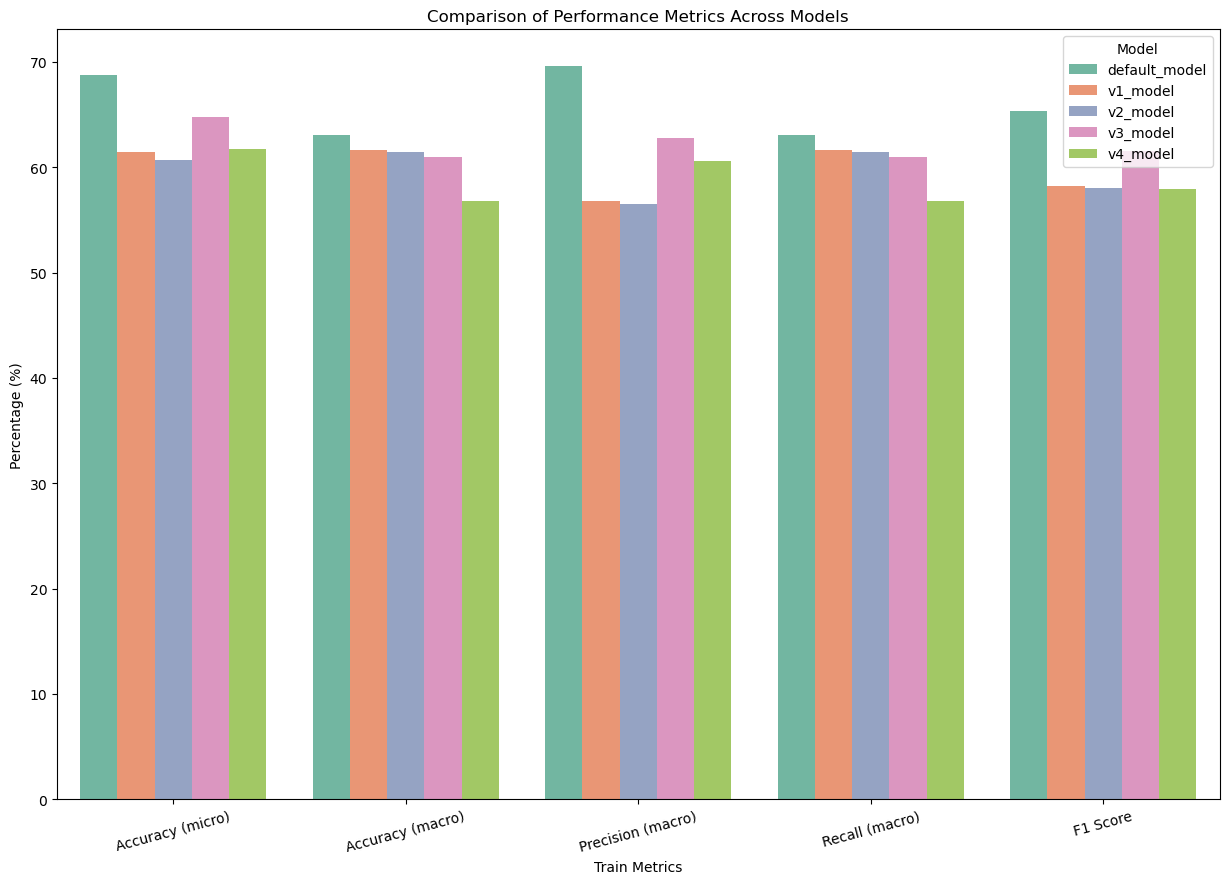

In [189]:
# Define the metrics to compare
metrics = ["Accuracy (micro)", "Accuracy (macro)", "Precision (macro)", "Recall (macro)", "F1 Score"]

# Reshape the dataframe for better visualization (melt operation)
train_results_melted = default_v1_v2_v3_v4_train.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 10))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=train_results_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Performance Metrics Across Models")
plt.ylabel("Percentage (%)")
plt.xlabel("Train Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

In [190]:
default_v1_v2_v3_v4_test = default_v1_v2_v3_v4_performance[default_v1_v2_v3_v4_performance['Train & Test']=='Test']
default_v1_v2_v3_v4_test

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
1  default_model         Test         86.007761         84.574111   
3       v1_model         Test         80.826295         83.259382   
5       v2_model         Test         73.910066         75.837529   
7       v3_model         Test         78.155672         77.735809   
9       v4_model         Test         74.754622         74.697969   

   Precision (macro)  Recall (macro)   F1 Score  Loss        Class_weights  \
1          86.983563       84.574111  85.038399   NaN                 None   
3          81.965625       83.259382  81.079335   NaN    inverse_frequency   
5          76.910937       75.837529  73.861801   NaN             balanced   
7          80.118981       77.735809  76.150374   NaN         sqrt_inverse   
9          81.426984       74.697969  75.293104   NaN  scaled_sqrt_inverse   

           Best_class                                    Median_class  \
1    Cenchrus divisus                      Heliotropium arborescens L   
3    Cenchrus divisus                   Lycium shawii Roem. & Schult.   
5  Calotropis procera                    Gymnocarpos decander Forssk.   
7  Peganum harmala L.  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze   
9  Calotropis procera                       Zilla spinosa (L.) Prantl   

                                     Worst_class  Num_classes_above_micro_avg  \
1  Iphiona mucronata (Forssk.) Asch. & Schweinf.                           17   
3                         Anabasis setifera Moq.                           24   
5   Zygophyllum molle (Delile) Christenh. & Byng                           19   
7                        Farsetia aegyptia Turra                           19   
9                   Deverra tortuosa (Desf.) DC.                           16   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
1                           18                              17   
3                           19                              17   
5                           18                              17   
7                           19                              17   
9                           16                              17   

   Time Taken (mins)  
1          13.012958  
3          13.693827  
5          13.527032  
7          13.453853  
9          13.456117

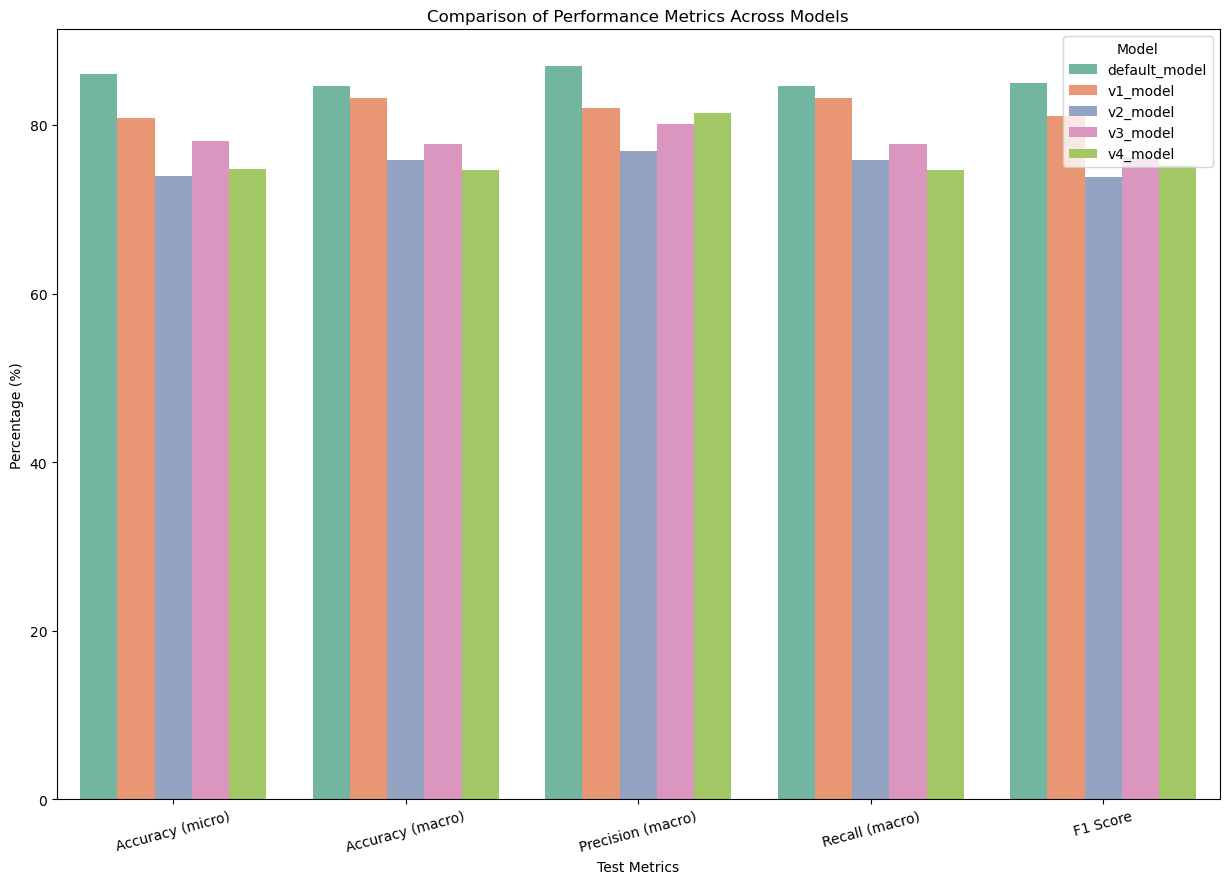

In [220]:
# Define the metrics to compare
metrics = ["Accuracy (micro)", "Accuracy (macro)", "Precision (macro)", "Recall (macro)", "F1 Score"]

# Reshape the dataframe for better visualization (melt operation)
test_results_melted = default_v1_v2_v3_v4_test.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 10))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=test_results_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Performance Metrics Across Models")
plt.ylabel("Percentage (%)")
plt.xlabel("Test Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

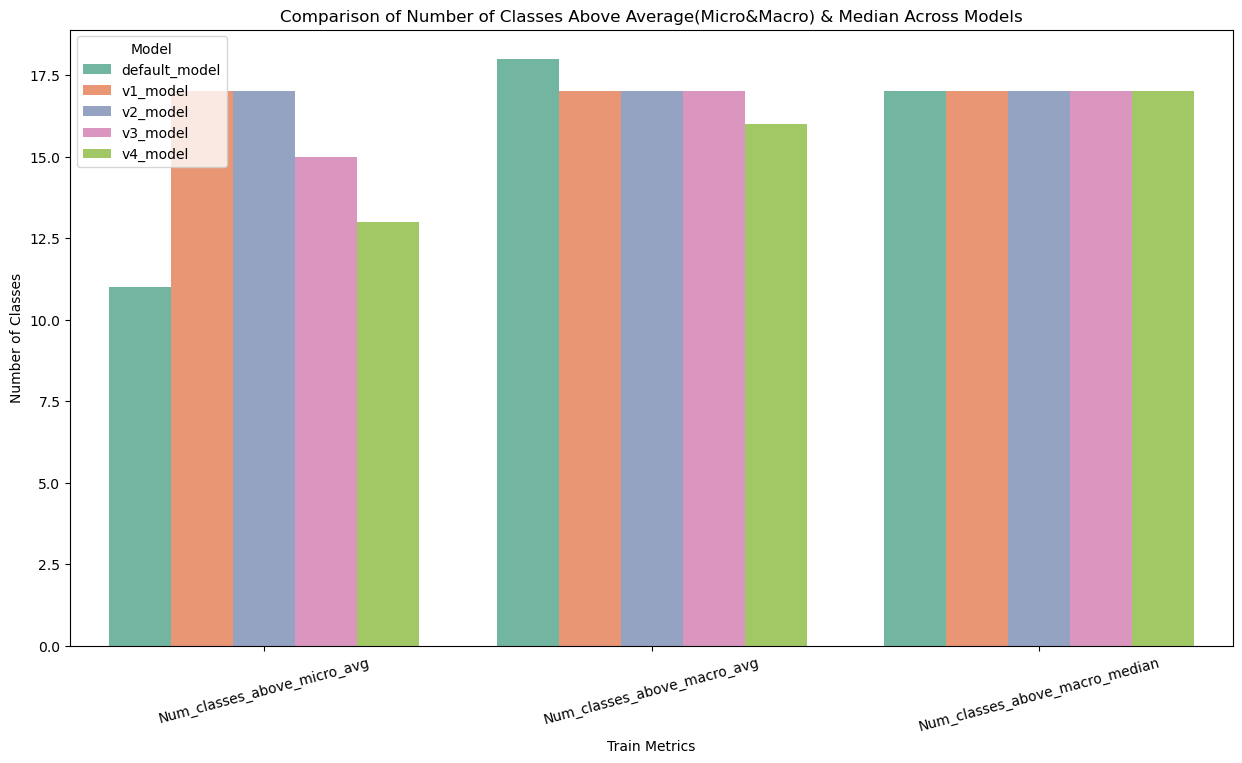

In [193]:
# Define the metrics to compare
class_metrics = [
    "Num_classes_above_micro_avg",
    "Num_classes_above_macro_avg",
    "Num_classes_above_macro_median"
]

# Reshape the dataframe for better visualization
train_class_melted = default_v1_v2_v3_v4_train.melt(id_vars=["Model"], value_vars=class_metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 8))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=train_class_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Number of Classes Above Average(Micro&Macro) & Median Across Models")
plt.ylabel("Number of Classes")
plt.xlabel("Train Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

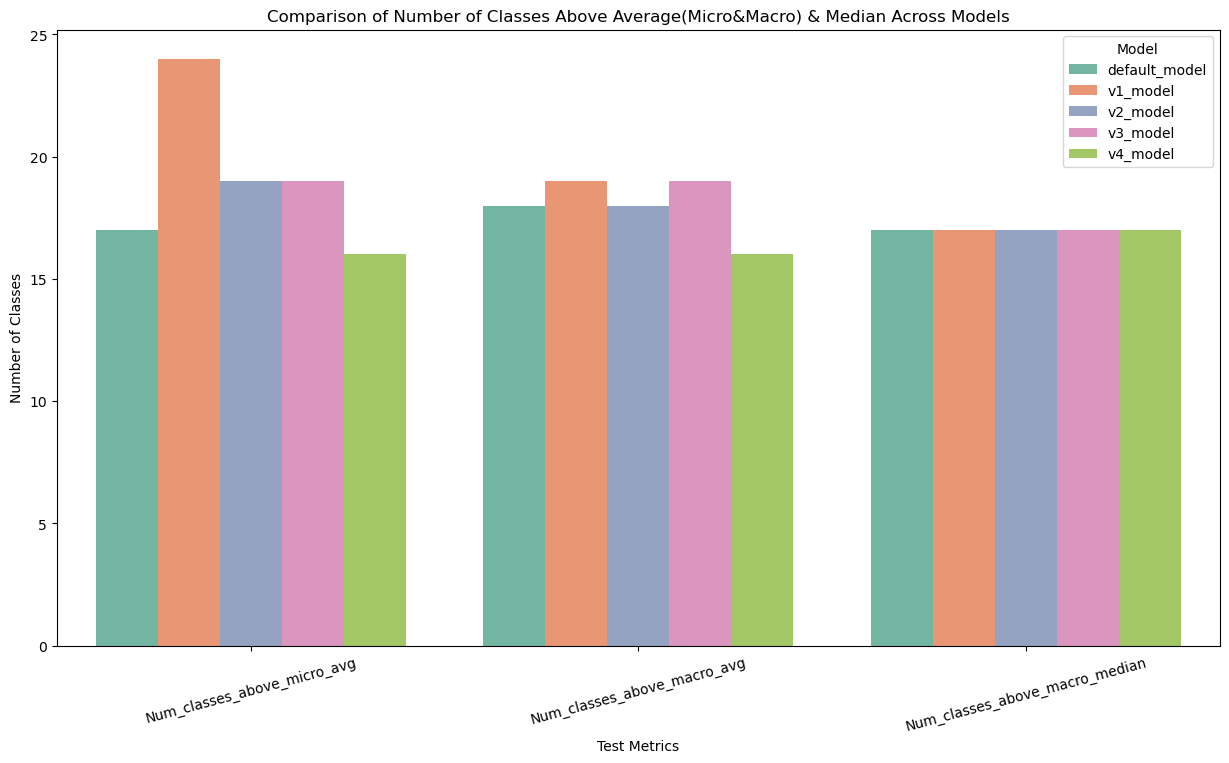

In [221]:
# Define the metrics to compare
class_metrics = [
    "Num_classes_above_micro_avg",
    "Num_classes_above_macro_avg",
    "Num_classes_above_macro_median"
]

# Reshape the dataframe for better visualization
test_class_melted = default_v1_v2_v3_v4_test.melt(id_vars=["Model"], value_vars=class_metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 8))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=test_class_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Number of Classes Above Average(Micro&Macro) & Median Across Models")
plt.ylabel("Number of Classes")
plt.xlabel("Test Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

- **The inverse frequency method achieves a trade-off between macro and micro averages, as well as the median, versus the number of classes exceeding each of these metrics in both training and testing.**
- **Therefore, it will be the chosen approach to compute class weights, ensuring a balanced contribution of each class to the loss function.**

## 1. Default

In [87]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [88]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [89]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
default_train_results, epoch_accuracy, epoch_loss = train_model(default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes)

In [ ]:
evaluate_model(default_model, test_loader, class_names=dataset.classes)

## 1. Default

In [87]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [88]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [89]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
default_train_results, epoch_accuracy, epoch_loss = train_model(default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes)

In [ ]:
evaluate_model(default_model, test_loader, class_names=dataset.classes)

## 1. Default

In [87]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [88]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [89]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
default_train_results, epoch_accuracy, epoch_loss = train_model(default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes)

In [ ]:
evaluate_model(default_model, test_loader, class_names=dataset.classes)

## 1. Default

In [87]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [88]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [89]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
default_train_results, epoch_accuracy, epoch_loss = train_model(default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes)

In [ ]:
evaluate_model(default_model, test_loader, class_names=dataset.classes)

## 1. Default

In [87]:
default_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [88]:
default_criterion = nn.CrossEntropyLoss()
default_optimizer = optim.Adamax(default_model.parameters(), lr=0.02)

### Training & Evaluation

In [89]:
dataset.transform = test_transforms
train_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
default_train_results, epoch_accuracy, epoch_loss = train_model(default_model, train_loader, default_criterion, default_optimizer, class_names=dataset.classes)

In [ ]:
evaluate_model(default_model, test_loader, class_names=dataset.classes)

In [58]:
default_train_metrics = train_model(MobileNet_V2_model, train_loader, MobileNet_V2_criterion, MobileNet_V2_optimizer, class_names=dataset.classes)

Epoch 1, Batch 100, Loss: 1.5698, Overall Accuracy: 57.22%, Time Passed: 9.63m
Epoch 1 Completed - Average Loss: 0.2934, Overall Accuracy: 57.22%, Epoch Time: 9.63m
Training Complete - Total Time: 577.78s


In [60]:
default_train_metrics

Species  Accuracy (%)  \
0                  Nitraria retusa (Forssk.) Asch.     37.671233   
1                       Heliotropium arborescens L     67.741935   
2                                       Salsola sp     85.245902   
3                          Farsetia aegyptia Turra     38.461538   
4                Diplotaxis harra (Forssk.) Boiss.     51.162791   
5                 Tamarix nilotica (Ehrenb.) Bunge     60.000000   
6                           Anabasis setifera Moq.     57.988166   
7                                 Cenchrus divisus     58.333333   
8                             Ephedra alata Decne.     79.874214   
9      Zygophyllum arabicum (L.) Christenh. & Byng     58.389262   
10                      Ochradenus baccatus Delile     68.641115   
11                   Lycium shawii Roem. & Schult.     65.740741   
12  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     68.181818   
13                             Rumex vesicarius L.     62.745098   
14                  Trichodesma africanum (L.) Sm.     52.112676   
15                       Zilla spinosa (L.) Prantl     43.209877   
16                              Calotropis procera     78.260870   
17                        Echinops glaberrimus DC.     67.938931   
18   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     50.000000   
19                             Capparis spinosa L.     49.152542   
20              Anabasis articulata (Forssk.) Moq.     61.538462   
21                   Limonium pruinosum (L.) Chaz.     32.258065   
22                           Zygophyllum coccineum     50.000000   
23    Zygophyllum molle (Delile) Christenh. & Byng     68.888889   
24             Suaeda aegyptiaca (Hasselq.) Zohary     63.333333   
25                             Atriplex halimus L.     45.833333   
26            Deverra triradiata Hochst. ex Boiss.     73.684211   
27                        Stachys aegyptiaca Pers.     40.476190   
28                    Gymnocarpos decander Forssk.     33.333333   
29                                   9_2_c unknown      0.000000   
30   Iphiona mucronata (Forssk.) Asch. & Schweinf.     78.571429   
31                              Peganum harmala L.      0.000000   
32                    Deverra tortuosa (Desf.) DC.     50.000000   
33                                          others      0.000000   
34                     Average Performance (Macro)     52.904979   

    Precision (macro)  Recall (macro)  
0             0.47862         0.52905  
1             0.47862         0.52905  
2             0.47862         0.52905  
3             0.47862         0.52905  
4             0.47862         0.52905  
5             0.47862         0.52905  
6             0.47862         0.52905  
7             0.47862         0.52905  
8             0.47862         0.52905  
9             0.47862         0.52905  
10            0.47862         0.52905  
11            0.47862         0.52905  
12            0.47862         0.52905  
13            0.47862         0.52905  
14            0.47862         0.52905  
15            0.47862         0.52905  
16            0.47862         0.52905  
17            0.47862         0.52905  
18            0.47862         0.52905  
19            0.47862         0.52905  
20            0.47862         0.52905  
21            0.47862         0.52905  
22            0.47862         0.52905  
23            0.47862         0.52905  
24            0.47862         0.52905  
25            0.47862         0.52905  
26            0.47862         0.52905  
27            0.47862         0.52905  
28            0.47862         0.52905  
29            0.47862         0.52905  
30            0.47862         0.52905  
31            0.47862         0.52905  
32            0.47862         0.52905  
33            0.47862         0.52905  
34            0.47862         0.52905

In [61]:
default_train_metrics['Accuracy (%)'][:-1].mean()

52.90497900151516

In [56]:
default_train_metrics['Recall (macro)'].mean()

0.2657220058745881

In [69]:
df_metrics

Species  Accuracy (%)  \
0                       Ochradenus baccatus Delile     92.409241   
1                    Lycium shawii Roem. & Schult.     90.665434   
2                       Heliotropium arborescens L     95.880682   
3      Zygophyllum arabicum (L.) Christenh. & Byng     93.743139   
4                               Peganum harmala L.    100.000000   
5                         Stachys aegyptiaca Pers.     95.165394   
6                           Anabasis setifera Moq.     92.941176   
7                     Deverra tortuosa (Desf.) DC.     99.218750   
8               Anabasis articulata (Forssk.) Moq.     96.000000   
9                Diplotaxis harra (Forssk.) Boiss.     93.961353   
10                        Echinops glaberrimus DC.     96.266667   
11                             Atriplex halimus L.     90.202020   
12                                      Salsola sp     96.979866   
13                                Cenchrus divisus     97.863248   
14             Suaeda aegyptiaca (Hasselq.) Zohary     96.307692   
15                            Ephedra alata Decne.     96.486826   
16                       Zilla spinosa (L.) Prantl     93.013100   
17                             Rumex vesicarius L.     98.235294   
18                             Capparis spinosa L.     97.050147   
19  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     95.384615   
20   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     92.284866   
21                         Farsetia aegyptia Turra     92.132505   
22                           Zygophyllum coccineum     94.484761   
23                    Gymnocarpos decander Forssk.     95.436508   
24                  Trichodesma africanum (L.) Sm.     94.897959   
25                              Calotropis procera     98.561151   
26                Tamarix nilotica (Ehrenb.) Bunge     95.246637   
27    Zygophyllum molle (Delile) Christenh. & Byng     98.023715   
28                 Nitraria retusa (Forssk.) Asch.     93.980344   
29            Deverra triradiata Hochst. ex Boiss.    100.000000   
30                   Limonium pruinosum (L.) Chaz.     95.583596   
31   Iphiona mucronata (Forssk.) Asch. & Schweinf.     98.198198   
32                                   9_2_c unknown     98.113208   
33                            Noise Images(others)     96.000000   
34         Retama raetam (Forssk.) Webb & Berthel.    100.000000   

    Precision (macro)  Recall (macro)  
0            0.926421        0.957348  
1            0.926421        0.957348  
2            0.926421        0.957348  
3            0.926421        0.957348  
4            0.926421        0.957348  
5            0.926421        0.957348  
6            0.926421        0.957348  
7            0.926421        0.957348  
8            0.926421        0.957348  
9            0.926421        0.957348  
10           0.926421        0.957348  
11           0.926421        0.957348  
12           0.926421        0.957348  
13           0.926421        0.957348  
14           0.926421        0.957348  
15           0.926421        0.957348  
16           0.926421        0.957348  
17           0.926421        0.957348  
18           0.926421        0.957348  
19           0.926421        0.957348  
20           0.926421        0.957348  
21           0.926421        0.957348  
22           0.926421        0.957348  
23           0.926421        0.957348  
24           0.926421        0.957348  
25           0.926421        0.957348  
26           0.926421        0.957348  
27           0.926421        0.957348  
28           0.926421        0.957348  
29           0.926421        0.957348  
30           0.926421        0.957348  
31           0.926421        0.957348  
32           0.926421        0.957348  
33           0.926421        0.957348  
34           0.926421        0.957348

Batch 100, Accuracy: 93.59%, Time Passed: 557.11s
Evaluation Complete - Accuracy: 93.09%, Total Time: 753.61s


## new implementation V1

In [378]:
from collections import Counter
import torch
import numpy as np

# Compute class frequencies
class_counts = Counter(dataset.targets)

# Compute class weights: sqrt-based inverse frequency
class_weights = {cls: (1 / np.sqrt(count)) for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float32)

# Move weights to MPS (Apple GPU) if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

## new implementation V2

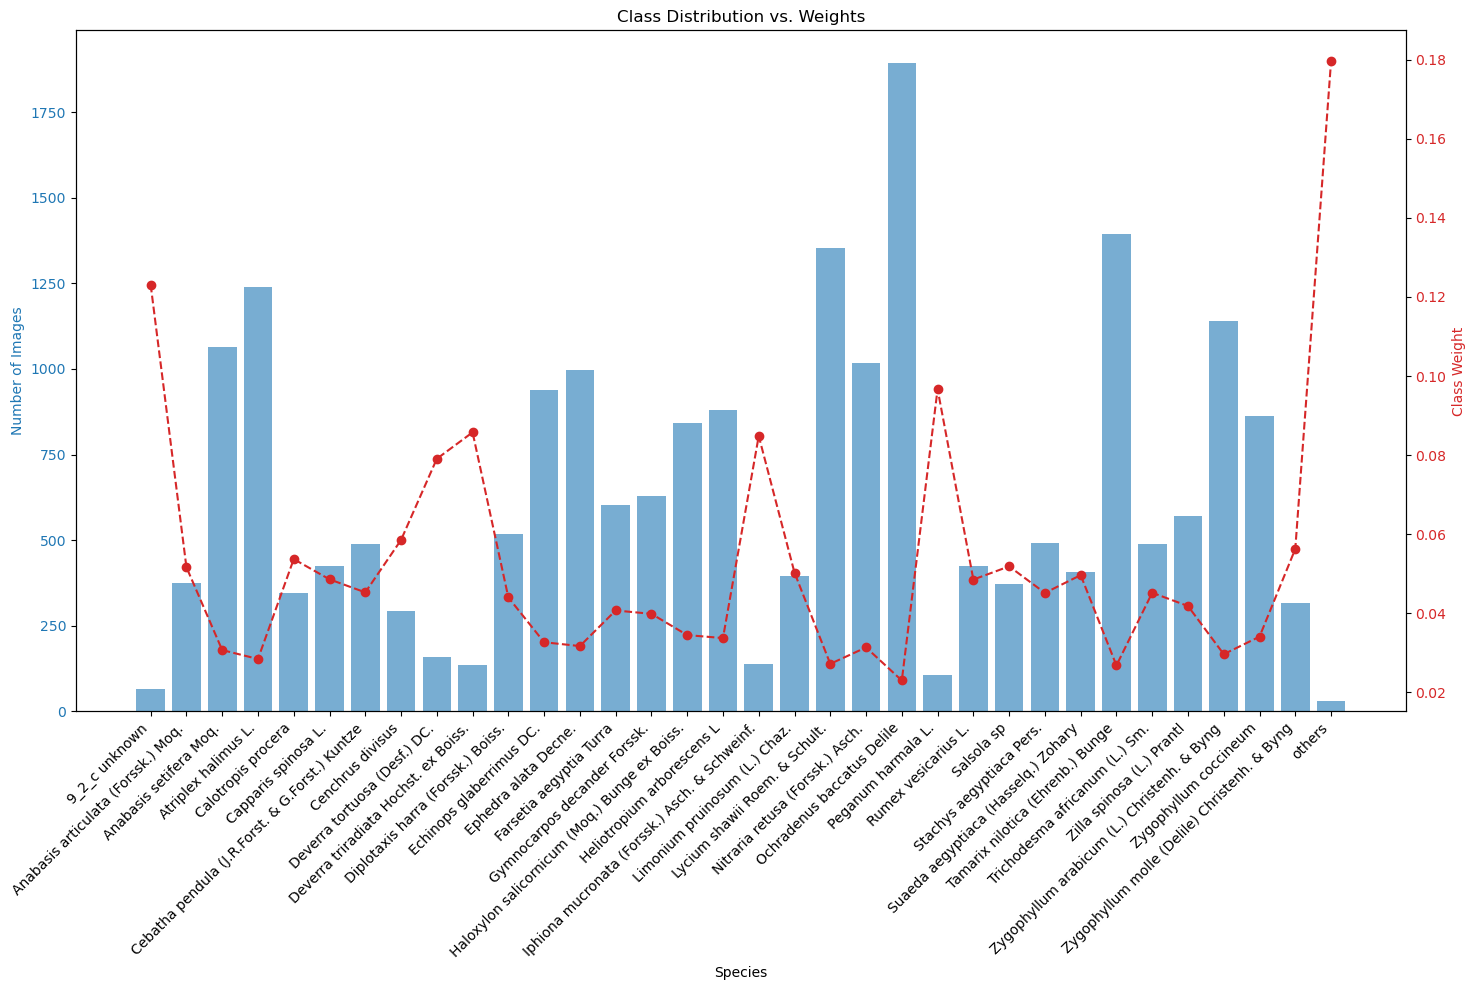

In [379]:
import matplotlib.pyplot as plt

# Get class names from dataset
species_names = dataset.classes  
num_images = [class_counts[cls] for cls in range(len(species_names))]
weights = [class_weights[cls] for cls in range(len(species_names))]

# Create figure
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot number of images (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Species')
ax1.set_ylabel('Number of Images', color=color)
ax1.bar(species_names, num_images, color=color, alpha=0.6, label="Number of Images")
ax1.tick_params(axis='y', labelcolor=color)

# Fix for x-axis labels
ax1.set_xticks(range(len(species_names)))  # Set tick positions
ax1.set_xticklabels(species_names, rotation=45, ha="right")  # Assign labels

# Create second y-axis to plot weights
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Class Weight', color=color)
ax2.plot(range(len(species_names)), weights, color=color, marker='o', linestyle='dashed', label="Class Weights")
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Class Distribution vs. Weights')
fig.tight_layout()
plt.show()

Epoch 1, Batch 10, Loss: 3.5504, Accuracy: 2.19%, Time Passed: 59.02s
Epoch 1, Batch 20, Loss: 3.5445, Accuracy: 2.19%, Time Passed: 120.98s
Epoch 1, Batch 30, Loss: 3.5414, Accuracy: 2.50%, Time Passed: 184.66s
Epoch 1, Batch 40, Loss: 3.5453, Accuracy: 2.27%, Time Passed: 246.88s
Epoch 1, Batch 50, Loss: 3.5448, Accuracy: 2.44%, Time Passed: 307.94s
Epoch 1, Batch 60, Loss: 3.5473, Accuracy: 2.50%, Time Passed: 371.29s
Epoch 1, Batch 70, Loss: 3.5465, Accuracy: 2.59%, Time Passed: 433.20s
Epoch 1, Batch 80, Loss: 3.5464, Accuracy: 2.62%, Time Passed: 494.17s
Epoch 1, Batch 90, Loss: 3.5461, Accuracy: 2.60%, Time Passed: 555.15s
Epoch 1, Batch 100, Loss: 3.5465, Accuracy: 2.56%, Time Passed: 615.05s
Epoch 1, Batch 110, Loss: 3.5470, Accuracy: 2.47%, Time Passed: 675.13s
Epoch 1, Batch 120, Loss: 3.5457, Accuracy: 2.42%, Time Passed: 736.04s
Epoch 1, Batch 130, Loss: 3.5455, Accuracy: 2.50%, Time Passed: 795.70s
Epoch 1, Batch 140, Loss: 3.5466, Accuracy: 2.43%, Time Passed: 856.30s
Ep

In [370]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, train_transforms, epoch):
    start_time = time.time()  # Start tracking time
    dataset.transform = train_transforms  # Augmentation for training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})


    for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Compute accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = 100 * correct / total

        # Store predictions for per-class metrics
        for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            class_metrics[label]["correct"] += (label == pred)
            class_metrics[label]["total"] += 1
            class_metrics[label]["y_true"].append(label)
            class_metrics[label]["y_pred"].append(pred)

        # Print loss and accuracy every 100 batches
        if batch_idx % 10 == 0:
            elapsed_time = (time.time() - start_time)/60
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                  f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}m")
    
    avg_loss = running_loss / len(train_loader)
    return avg_loss, accuracy, class_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
train_one_epoch(MobileNet_V2_model, train_loader, MobileNet_criterion, MobileNet_optimizer, device, train_transforms, epoch=1)

Epoch 1, Batch 10, Loss: 3.5653, Accuracy: 1.56%, Time Passed: 1.81m
Epoch 1, Batch 20, Loss: 3.5647, Accuracy: 2.19%, Time Passed: 3.64m
Epoch 1, Batch 30, Loss: 3.5652, Accuracy: 1.88%, Time Passed: 5.55m
Epoch 1, Batch 40, Loss: 3.5577, Accuracy: 2.19%, Time Passed: 7.44m
Epoch 1, Batch 50, Loss: 3.5577, Accuracy: 2.19%, Time Passed: 9.27m


KeyboardInterrupt: 

In [ ]:
print(f"Epoch {epoch+4}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, " f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+4} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

    # Calculate per-class accuracy, precision, and recall
    class_results = []
    all_y_true = []
    all_y_pred = []

    for class_idx, metrics in class_metrics.items():
        accuracy = 100 * metrics["correct"] / metrics["total"]
        all_y_true.extend(metrics["y_true"])
        all_y_pred.extend(metrics["y_pred"])
        class_results.append([class_names[class_idx], accuracy])

    # Compute macro & weighted precision/recall
    precision = precision_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average="macro", zero_division=0)

    # Create a DataFrame with per-class accuracy and overall precision/recall
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)"])
    df_results["Precision (macro)"] = precision
    df_results["Recall (macro)"] = recall

    return df_results

# Example usage:
df_metrics = train_model(model, train_loader, test_loader, criterion, optimizer, class_names=dataset.classes)

In [ ]:





def evaluate_one_epoch(model, test_loader, device, test_transforms):
    dataset.transform = test_transforms  # No augmentation for testing
    model.eval()
    correct, total = 0, 0
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})
    all_y_true, all_y_pred = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_y_true.extend(labels.cpu().numpy())
            all_y_pred.extend(preds.cpu().numpy())
            
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)
    
    accuracy = 100 * correct / total
    return accuracy, class_metrics, all_y_true, all_y_pred

def compute_per_class_metrics(class_metrics, class_names):
    results = []
    all_y_true, all_y_pred = [], []
    
    for class_idx, metrics in class_metrics.items():
        accuracy = 100 * metrics["correct"] / metrics["total"] if metrics["total"] > 0 else 0
        all_y_true.extend(metrics["y_true"])
        all_y_pred.extend(metrics["y_pred"])
        results.append([class_names[class_idx], accuracy])
    
    precision = precision_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    
    df_results = pd.DataFrame(results, columns=["Species", "Accuracy (%)"])
    df_results["Precision (macro)"] = precision
    df_results["Recall (macro)"] = recall
    return df_results

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, class_names, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    history = []
    per_class_metrics_history = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_accuracy, train_class_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_accuracy, test_class_metrics, all_y_true, all_y_pred = evaluate_one_epoch(model, test_loader, device)
        
        elapsed_time = time.time() - start_time
        
        history.append([epoch+1, train_loss, train_accuracy, test_accuracy, elapsed_time])
        per_class_df = compute_per_class_metrics(test_class_metrics, class_names)
        per_class_df.insert(0, "Epoch", epoch+1)
        per_class_metrics_history.append(per_class_df)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%, Time: {elapsed_time:.2f}s")
    
    df_history = pd.DataFrame(history, columns=["Epoch", "Train Loss", "Train Accuracy (%)", "Test Accuracy (%)", "Time (s)"])
    df_per_class_metrics = pd.concat(per_class_metrics_history, ignore_index=True)
    
    return df_history, df_per_class_metrics

# Example usage:
df_metrics_1, df_per_class_1 = train_and_evaluate(MobileNet_V2_model, train_loader, test_loader, MobileNet_criterion, MobileNet_optimizer, class_names=dataset.classes)


In [43]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze first layers (keep only last 20 trainable)
for param in list(model.features.parameters())[:-20]:
    param.requires_grad = False

# Replace classifier with our own (for N classes)
num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, num_classes)
)

# Move model to GPU if available
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/drmorsy/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:03<00:00, 3.57MB/s]


In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Class weighting applied
optimizer = optim.Adamax(model.parameters(), lr=0.02)

In [55]:
import time

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1):
    start_time = time.time()  # Start tracking time

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1, Batch 100, Loss: 2.2697, Accuracy: 42.31%, Time Passed: 598.76s
Epoch 1, Batch 200, Loss: 1.9803, Accuracy: 49.05%, Time Passed: 1199.60s
Epoch 1, Batch 300, Loss: 1.7105, Accuracy: 55.14%, Time Passed: 1799.19s
Epoch 1, Batch 400, Loss: 1.5047, Accuracy: 59.57%, Time Passed: 2405.27s
Epoch 1, Batch 500, Loss: 1.3445, Accuracy: 63.15%, Time Passed: 3009.38s
Epoch 1 Completed - Average Loss: 1.3033, Accuracy: 64.14%, Epoch Time: 3223.83s
Training Complete - Total Time: 3223.83s


In [56]:
import time

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1):
    start_time = time.time()  # Start tracking time

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+2} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1, Batch 100, Loss: 0.5247, Accuracy: 81.84%, Time Passed: 621.66s
Epoch 1, Batch 200, Loss: 0.4869, Accuracy: 83.08%, Time Passed: 1241.74s
Epoch 1, Batch 300, Loss: 0.4920, Accuracy: 83.44%, Time Passed: 1847.79s
Epoch 1, Batch 400, Loss: 0.4737, Accuracy: 84.12%, Time Passed: 2454.01s
Epoch 1, Batch 500, Loss: 0.4561, Accuracy: 84.61%, Time Passed: 3046.48s
Epoch 2 Completed - Average Loss: 0.4496, Accuracy: 84.68%, Epoch Time: 3263.04s
Training Complete - Total Time: 3263.05s


In [58]:
import time

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1):
    start_time = time.time()  # Start tracking time

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+3}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+3} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 3, Batch 100, Loss: 0.2342, Accuracy: 91.03%, Time Passed: 584.81s
Epoch 3, Batch 200, Loss: 0.2384, Accuracy: 90.88%, Time Passed: 1185.16s
Epoch 3, Batch 300, Loss: 0.2599, Accuracy: 90.34%, Time Passed: 1797.78s
Epoch 3, Batch 400, Loss: 0.2663, Accuracy: 90.18%, Time Passed: 2409.94s
Epoch 3, Batch 500, Loss: 0.2550, Accuracy: 90.54%, Time Passed: 3029.93s
Epoch 3 Completed - Average Loss: 0.2532, Accuracy: 90.58%, Epoch Time: 3249.47s
Training Complete - Total Time: 3249.48s


In [60]:
import time
import torch
import pandas as pd
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score

def train_model(model, train_loader, test_loader, criterion, optimizer, class_names, num_epochs=1):
    start_time = time.time()  # Start tracking time
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")  # Use GPU if available on Mac

    # Dictionary to store per-class metrics
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Store predictions for per-class metrics
            for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

    # Calculate per-class accuracy, precision, and recall
    class_results = []
    for class_idx, metrics in class_metrics.items():
        accuracy = 100 * metrics["correct"] / metrics["total"]
        precision = precision_score(metrics["y_true"], metrics["y_pred"], average="binary", zero_division=0)
        recall = recall_score(metrics["y_true"], metrics["y_pred"], average="binary", zero_division=0)
        class_results.append([class_names[class_idx], accuracy, precision, recall])

    # Create a DataFrame with per-class metrics
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)", "Precision", "Recall"])

    return df_results

# Example usage:
df_metrics = train_model(model, train_loader, test_loader, criterion, optimizer, class_names=dataset.classes)

Epoch 1, Batch 100, Loss: 0.1823, Accuracy: 93.88%, Time Passed: 622.22s
Epoch 1, Batch 200, Loss: 0.1804, Accuracy: 93.44%, Time Passed: 1250.71s
Epoch 1, Batch 300, Loss: 0.1852, Accuracy: 93.26%, Time Passed: 1866.00s
Epoch 1, Batch 400, Loss: 0.1831, Accuracy: 93.39%, Time Passed: 2475.77s
Epoch 1, Batch 500, Loss: 0.1821, Accuracy: 93.38%, Time Passed: 3085.80s
Epoch 1 Completed - Average Loss: 0.1852, Accuracy: 93.25%, Epoch Time: 3300.10s
Training Complete - Total Time: 3300.10s


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [68]:
import time
import torch
import pandas as pd
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score

def train_model(model, train_loader, test_loader, criterion, optimizer, class_names, num_epochs=1):
    start_time = time.time()  # Start tracking time
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")  # Use GPU if available on Mac

    # Dictionary to store per-class metrics
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_start_time = time.time()  # Track epoch time

        for batch_idx, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Store predictions for per-class metrics
            for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)

            # Print loss and accuracy every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Epoch {epoch+4}, Batch {batch_idx}, Loss: {running_loss/batch_idx:.4f}, "
                      f"Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+4} Completed - Average Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {accuracy:.2f}%, Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Training Complete - Total Time: {total_time:.2f}s")

    # Calculate per-class accuracy, precision, and recall
    class_results = []
    all_y_true = []
    all_y_pred = []

    for class_idx, metrics in class_metrics.items():
        accuracy = 100 * metrics["correct"] / metrics["total"]
        all_y_true.extend(metrics["y_true"])
        all_y_pred.extend(metrics["y_pred"])
        class_results.append([class_names[class_idx], accuracy])

    # Compute macro & weighted precision/recall
    precision = precision_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average="macro", zero_division=0)

    # Create a DataFrame with per-class accuracy and overall precision/recall
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)"])
    df_results["Precision (macro)"] = precision
    df_results["Recall (macro)"] = recall

    return df_results

# Example usage:
df_metrics = train_model(model, train_loader, test_loader, criterion, optimizer, class_names=dataset.classes)

Epoch 4, Batch 100, Loss: 0.0985, Accuracy: 96.22%, Time Passed: 606.56s
Epoch 4, Batch 200, Loss: 0.1054, Accuracy: 95.61%, Time Passed: 1217.74s
Epoch 4, Batch 300, Loss: 0.1180, Accuracy: 95.30%, Time Passed: 1839.14s
Epoch 4, Batch 400, Loss: 0.1298, Accuracy: 94.98%, Time Passed: 2451.54s
Epoch 4, Batch 500, Loss: 0.1455, Accuracy: 94.44%, Time Passed: 3058.09s
Epoch 4 Completed - Average Loss: 0.1477, Accuracy: 94.37%, Epoch Time: 3270.95s
Training Complete - Total Time: 3270.95s


In [69]:
df_metrics

Species  Accuracy (%)  \
0                       Ochradenus baccatus Delile     92.409241   
1                    Lycium shawii Roem. & Schult.     90.665434   
2                       Heliotropium arborescens L     95.880682   
3      Zygophyllum arabicum (L.) Christenh. & Byng     93.743139   
4                               Peganum harmala L.    100.000000   
5                         Stachys aegyptiaca Pers.     95.165394   
6                           Anabasis setifera Moq.     92.941176   
7                     Deverra tortuosa (Desf.) DC.     99.218750   
8               Anabasis articulata (Forssk.) Moq.     96.000000   
9                Diplotaxis harra (Forssk.) Boiss.     93.961353   
10                        Echinops glaberrimus DC.     96.266667   
11                             Atriplex halimus L.     90.202020   
12                                      Salsola sp     96.979866   
13                                Cenchrus divisus     97.863248   
14             Suaeda aegyptiaca (Hasselq.) Zohary     96.307692   
15                            Ephedra alata Decne.     96.486826   
16                       Zilla spinosa (L.) Prantl     93.013100   
17                             Rumex vesicarius L.     98.235294   
18                             Capparis spinosa L.     97.050147   
19  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     95.384615   
20   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     92.284866   
21                         Farsetia aegyptia Turra     92.132505   
22                           Zygophyllum coccineum     94.484761   
23                    Gymnocarpos decander Forssk.     95.436508   
24                  Trichodesma africanum (L.) Sm.     94.897959   
25                              Calotropis procera     98.561151   
26                Tamarix nilotica (Ehrenb.) Bunge     95.246637   
27    Zygophyllum molle (Delile) Christenh. & Byng     98.023715   
28                 Nitraria retusa (Forssk.) Asch.     93.980344   
29            Deverra triradiata Hochst. ex Boiss.    100.000000   
30                   Limonium pruinosum (L.) Chaz.     95.583596   
31   Iphiona mucronata (Forssk.) Asch. & Schweinf.     98.198198   
32                                   9_2_c unknown     98.113208   
33                            Noise Images(others)     96.000000   
34         Retama raetam (Forssk.) Webb & Berthel.    100.000000   

    Precision (macro)  Recall (macro)  
0            0.926421        0.957348  
1            0.926421        0.957348  
2            0.926421        0.957348  
3            0.926421        0.957348  
4            0.926421        0.957348  
5            0.926421        0.957348  
6            0.926421        0.957348  
7            0.926421        0.957348  
8            0.926421        0.957348  
9            0.926421        0.957348  
10           0.926421        0.957348  
11           0.926421        0.957348  
12           0.926421        0.957348  
13           0.926421        0.957348  
14           0.926421        0.957348  
15           0.926421        0.957348  
16           0.926421        0.957348  
17           0.926421        0.957348  
18           0.926421        0.957348  
19           0.926421        0.957348  
20           0.926421        0.957348  
21           0.926421        0.957348  
22           0.926421        0.957348  
23           0.926421        0.957348  
24           0.926421        0.957348  
25           0.926421        0.957348  
26           0.926421        0.957348  
27           0.926421        0.957348  
28           0.926421        0.957348  
29           0.926421        0.957348  
30           0.926421        0.957348  
31           0.926421        0.957348  
32           0.926421        0.957348  
33           0.926421        0.957348  
34           0.926421        0.957348

In [70]:
import time
import torch
import pandas as pd
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, class_names):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    
    start_time = time.time()  # Track evaluation time

    # Dictionary to store per-class metrics
    class_metrics = defaultdict(lambda: {"correct": 0, "total": 0, "y_true": [], "y_pred": []})
    all_y_true = []
    all_y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader, 1):  # Start index from 1
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_y_true.extend(labels.cpu().numpy())
            all_y_pred.extend(preds.cpu().numpy())

            # Compute accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total

            # Store per-class metrics
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_metrics[label]["correct"] += (label == pred)
                class_metrics[label]["total"] += 1
                class_metrics[label]["y_true"].append(label)
                class_metrics[label]["y_pred"].append(pred)

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                elapsed_time = time.time() - start_time
                print(f"Batch {batch_idx}, Accuracy: {accuracy:.2f}%, Time Passed: {elapsed_time:.2f}s")

    total_time = time.time() - start_time
    print(f"Evaluation Complete - Accuracy: {accuracy:.2f}%, Total Time: {total_time:.2f}s")

    # Compute per-class accuracy
    class_results = []
    for class_idx, metrics in class_metrics.items():
        accuracy = 100 * metrics["correct"] / metrics["total"]
        class_results.append([class_names[class_idx], accuracy])

    # Compute macro & weighted precision/recall
    precision = precision_score(all_y_true, all_y_pred, average="macro", zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average="macro", zero_division=0)

    # Create a DataFrame with per-class accuracy and overall precision/recall
    df_results = pd.DataFrame(class_results, columns=["Species", "Accuracy (%)"])
    df_results["Precision (macro)"] = precision
    df_results["Recall (macro)"] = recall

    return df_results

# Example usage:
df_test_metrics = evaluate_model(model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 93.59%, Time Passed: 557.11s
Evaluation Complete - Accuracy: 93.09%, Total Time: 753.61s


In [71]:
df_test_metrics

Species  Accuracy (%)  \
0                           Anabasis setifera Moq.     86.384977   
1                            Zygophyllum coccineum     93.641618   
2      Zygophyllum arabicum (L.) Christenh. & Byng     91.666667   
3                                       Salsola sp     98.648649   
4                     Gymnocarpos decander Forssk.     96.031746   
5                       Heliotropium arborescens L     95.454545   
6                              Capparis spinosa L.     92.941176   
7                    Lycium shawii Roem. & Schult.     92.988930   
8                        Zilla spinosa (L.) Prantl     75.438596   
9                 Tamarix nilotica (Ehrenb.) Bunge     92.831541   
10                         Farsetia aegyptia Turra     85.950413   
11            Deverra triradiata Hochst. ex Boiss.    100.000000   
12                             Atriplex halimus L.     90.322581   
13                  Trichodesma africanum (L.) Sm.     87.755102   
14                      Ochradenus baccatus Delile     94.459103   
15                        Stachys aegyptiaca Pers.     96.938776   
16                            Ephedra alata Decne.     92.964824   
17                    Deverra tortuosa (Desf.) DC.    100.000000   
18  Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze    100.000000   
19                             Rumex vesicarius L.     95.294118   
20                        Echinops glaberrimus DC.     98.936170   
21   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     94.047619   
22                                Cenchrus divisus    100.000000   
23               Diplotaxis harra (Forssk.) Boiss.     91.262136   
24                 Nitraria retusa (Forssk.) Asch.     91.176471   
25                   Limonium pruinosum (L.) Chaz.     94.936709   
26             Suaeda aegyptiaca (Hasselq.) Zohary     98.765432   
27              Anabasis articulata (Forssk.) Moq.     93.333333   
28                              Peganum harmala L.    100.000000   
29    Zygophyllum molle (Delile) Christenh. & Byng     95.238095   
30   Iphiona mucronata (Forssk.) Asch. & Schweinf.    100.000000   
31                              Calotropis procera     98.550725   
32                                   9_2_c unknown    100.000000   
33                            Noise Images(others)     66.666667   
34         Retama raetam (Forssk.) Webb & Berthel.    100.000000   

    Precision (macro)  Recall (macro)  
0            0.931129        0.937893  
1            0.931129        0.937893  
2            0.931129        0.937893  
3            0.931129        0.937893  
4            0.931129        0.937893  
5            0.931129        0.937893  
6            0.931129        0.937893  
7            0.931129        0.937893  
8            0.931129        0.937893  
9            0.931129        0.937893  
10           0.931129        0.937893  
11           0.931129        0.937893  
12           0.931129        0.937893  
13           0.931129        0.937893  
14           0.931129        0.937893  
15           0.931129        0.937893  
16           0.931129        0.937893  
17           0.931129        0.937893  
18           0.931129        0.937893  
19           0.931129        0.937893  
20           0.931129        0.937893  
21           0.931129        0.937893  
22           0.931129        0.937893  
23           0.931129        0.937893  
24           0.931129        0.937893  
25           0.931129        0.937893  
26           0.931129        0.937893  
27           0.931129        0.937893  
28           0.931129        0.937893  
29           0.931129        0.937893  
30           0.931129        0.937893  
31           0.931129        0.937893  
32           0.931129        0.937893  
33           0.931129        0.937893  
34           0.931129        0.937893

In [68]:
DatasetSpeciesLoader = DataLoader(DatasetSpecies, 
                            shuffle=True,
                            batch_size=4)
DatasetElement = next(iter(DatasetSpeciesLoader))
DatasetElement[0].shape, DatasetElement[1].shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [69]:
image = DatasetElement[0][0].permute(1,2,0)
image.shape

torch.Size([224, 224, 3])

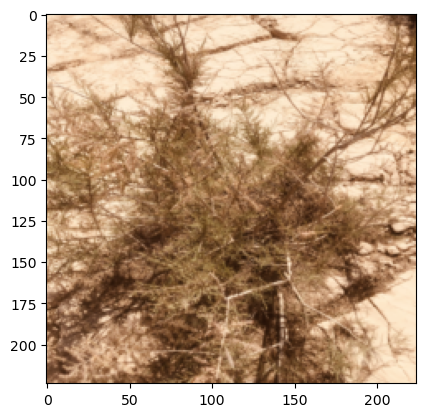

In [70]:
plt.imshow(image)
plt.show()

In [151]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = nn.Sequential( nn.Conv2d(3, 32, kernel_size=3, padding=1),
                                                nn.ELU(),
                                                nn.MaxPool2d(kernel_size=2),
                                                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                                nn.ELU(),
                                                nn.MaxPool2d(kernel_size=2),
                                                nn.Flatten()
                                              )

        

    def forward(self, x):
        self.w = x.shape[2]
        self.h = x.shape[3]
        self.clasifier = nn.Linear(64*int(self.w/4)*int(self.h/4), self.num_classes)
        x = self.feature_extractor(x)
        x = self.clasifier(x)
        return x
        

In [152]:
model = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [155]:
for epoch in range(1):
    running_loss = 0.0
    # Iterate over training batches
    for i, (images, labels) in enumerate(AmaranthaceaeLoader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1)%100 == 0:
            print(f'Loss after {i+1} batches: {running_loss}')
        
    
    epoch_loss = running_loss / len(AmaranthaceaeLoader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Loss after 100 batches: 195.3633772134781
Loss after 200 batches: 391.07457435131073
Loss after 300 batches: 586.5130313634872
Loss after 400 batches: 781.1541950702667
Loss after 500 batches: 977.0098805427551
Loss after 600 batches: 1171.7461366653442
Loss after 700 batches: 1367.6956629753113
Loss after 800 batches: 1563.838527083397
Epoch 1, Loss: 1.9550


In [138]:
len(AmaranthaceaeLoader)

850

#### Multi-class model evaluation

**In this multi-class classification task it is important how you average the scores over classes. Recall that there are four approaches:**
- Not averaging, and analyzing the results per class.
- Micro-averaging, ignoring the classes and computing the metrics globally.
- Macro-averaging, computing metrics per class and averaging them.
- Weighted-averaging, just like macro but with the average weighted by class size.

**When to use each:**
- Micro: Imbalanced datasets
- Macro: Care about performance on small classes
- Weighted: Consider errors in larger classes as more important

In [169]:
from torchmetrics import Recall, Precision

In [74]:
# Define metrics
#Define precision and recall metrics calculated globally on all examples.

metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

64

In [ ]:
# Define metrics
#Change your code to compute separate recall and precision metrics for each class and average them with a simple average.
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Analyzing metrics per class
While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

In [175]:
# Define precision metric
metric_precision = Precision(task="multiclass", num_classes=7, average=None)

model.eval()
with torch.no_grad():
    for images, labels in TestAmaranthaceaeLoader:
        outputs = model(images)
        i, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in TestDatasetAmaranthaceae.class_to_idx.items()
}
print(precision_per_class)

{'Anabasis articulata (Forssk.) Moq.': 0.05343511328101158, 'Anabasis setifera Moq.': 0.30912864208221436, 'Atriplex halimus L.': 0.3380855321884155, 'Caroxylon vermiculatum (L.) Akhani & Roalson': 0.027484143152832985, 'Haloxylon salicornicum (Moq.) Bunge ex Boiss.': 0.1624472588300705, 'Salsola sp': 0.037773359566926956, 'Suaeda aegyptiaca (Hasselq.) Zohary': 0.09111110866069794}


In [172]:
len(TestDatasetAmaranthaceae.classes)

7

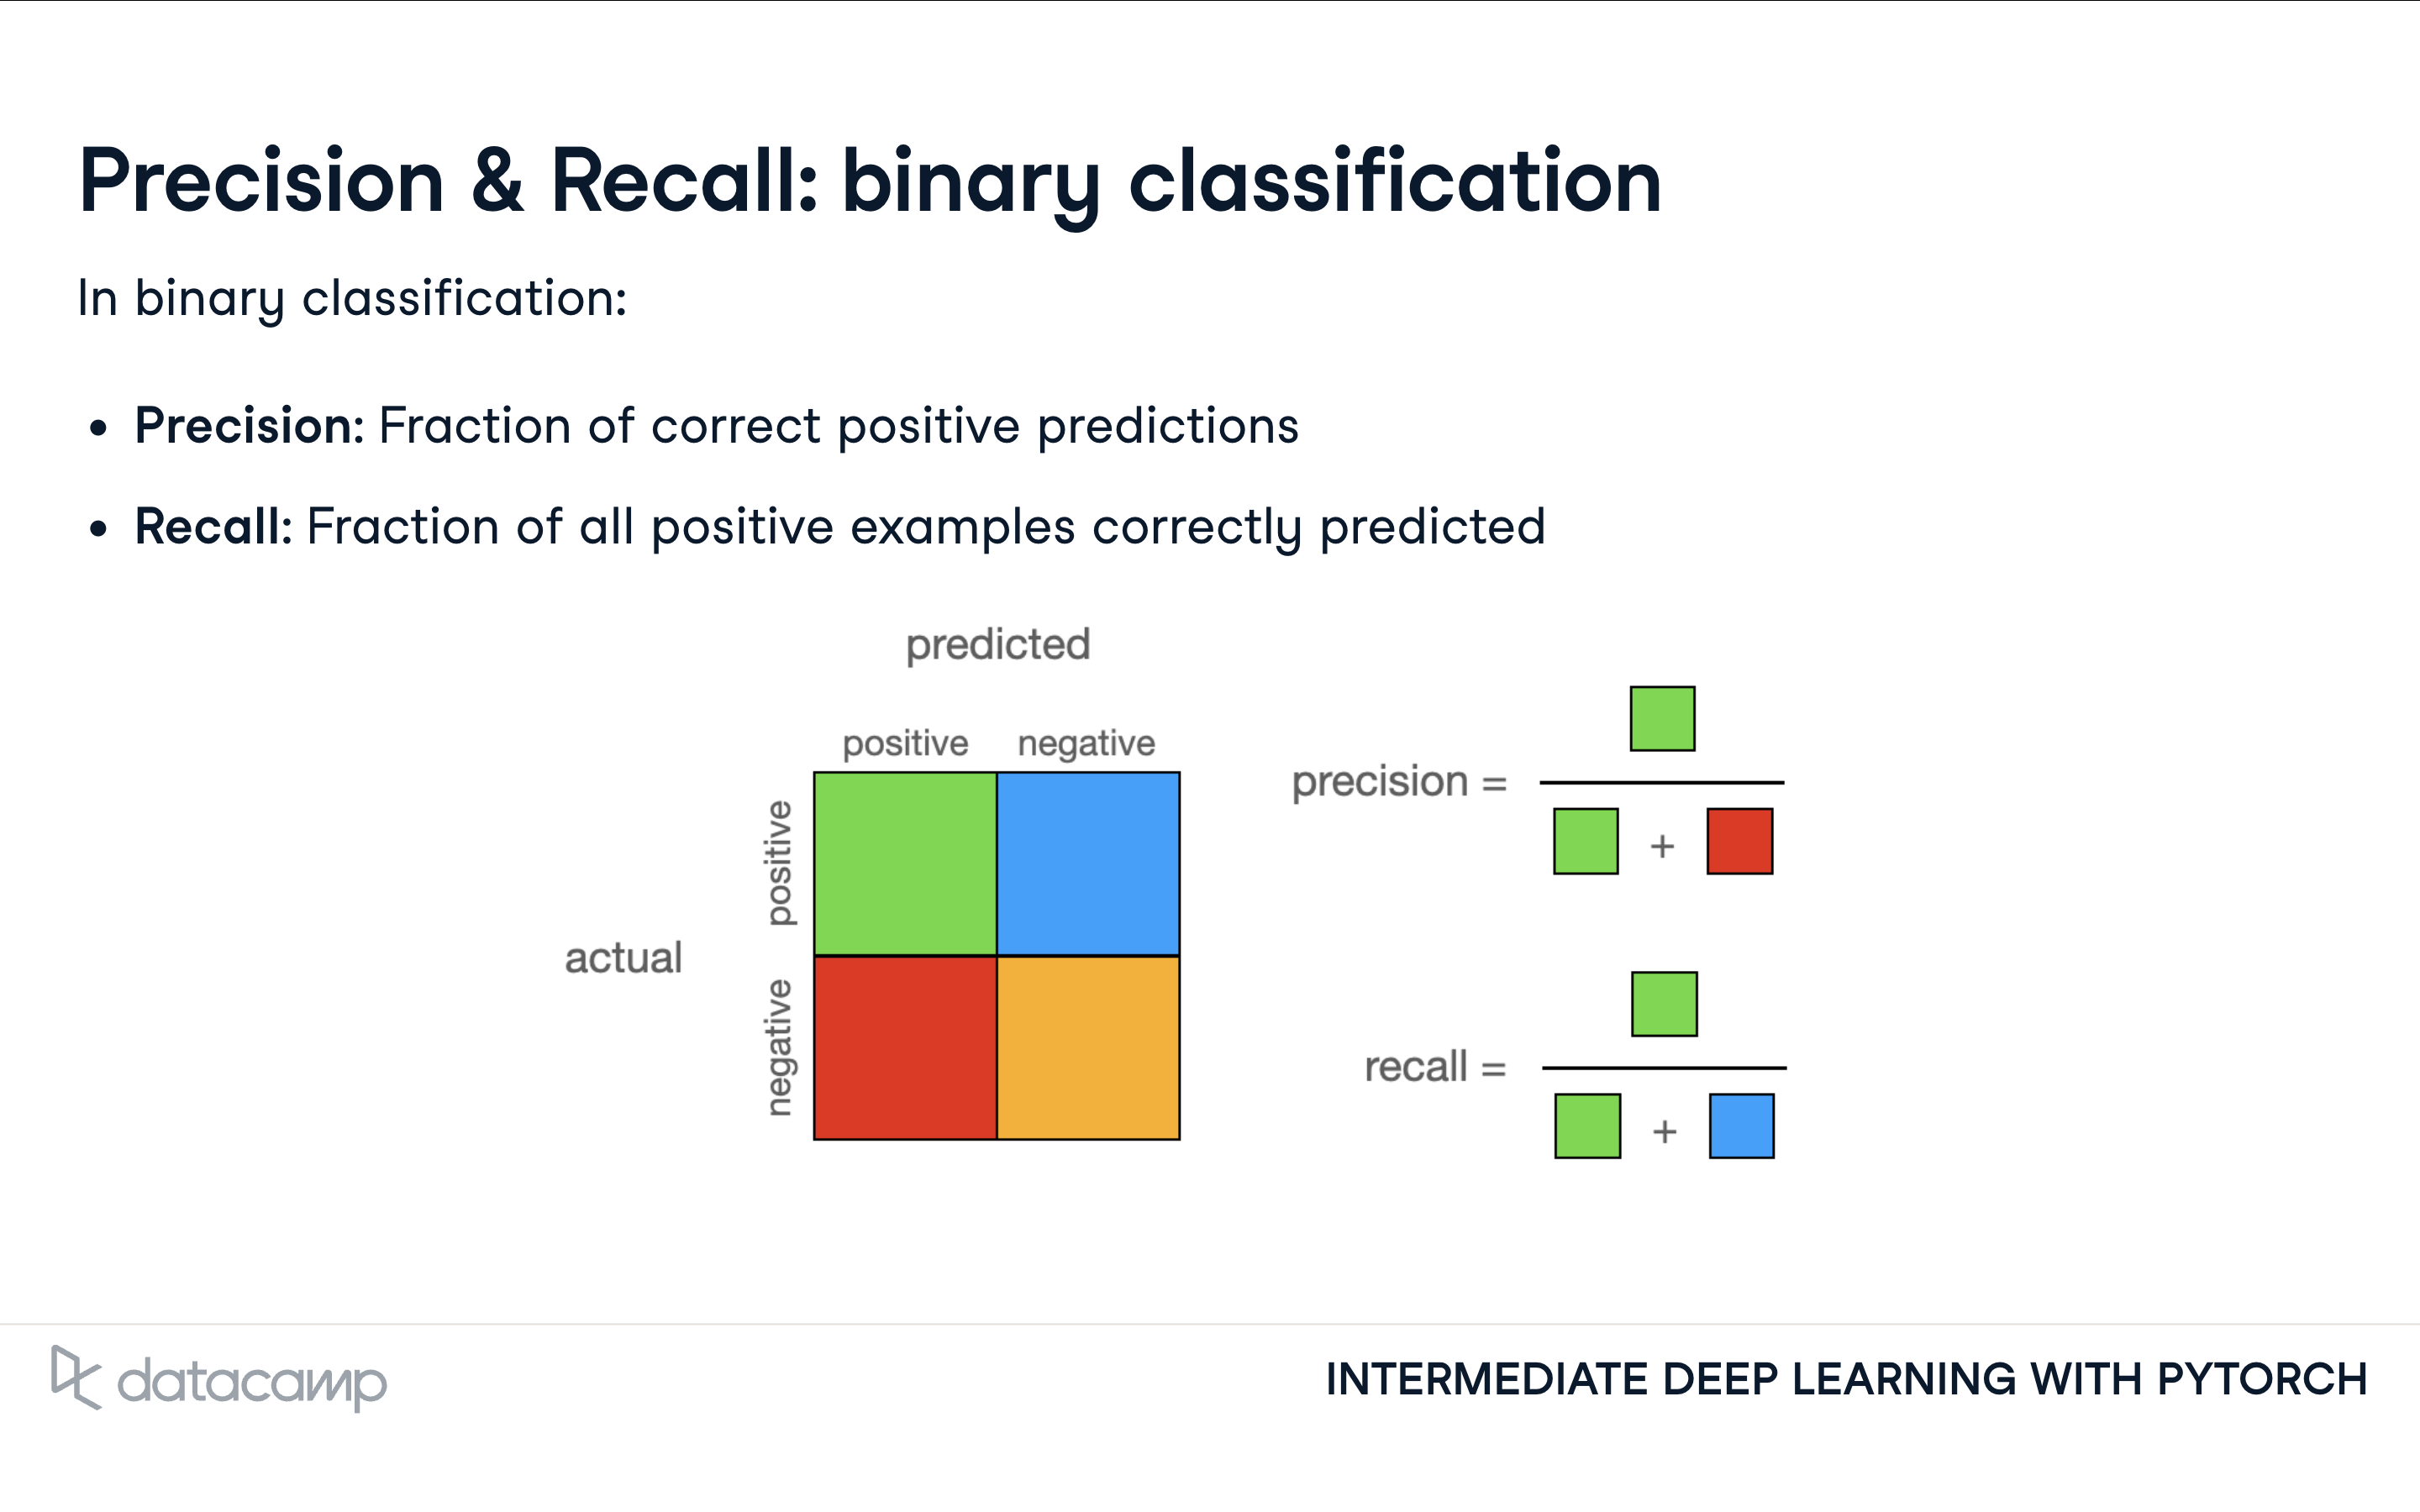

In [176]:
from IPython.display import Image
Image(filename='percison-recall.png') 

In [6]:
ls

Data_summary.ipynb         Untitled.ipynb
FamilySpeciesDataset.csv   Useful info/
FamilySpeciesDataset.xls   file.html
FamilySpeciesDataset.xlsx  percison-recall.png
GPS/                       summary_table.csv
Plants/


In [3]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 594.2 kB/s eta 0:00:00a 0:00:01


Here, we just sum the two partial losses together, indicating that the accuracy of predicting the alphabet and the character is equally important. If that is not the case, we can weigh the partial losses with some weights to reflect their relative importance. We will explore this idea later in the next video. Finally, we run backpropagation and the optimization step as always.

In [16]:
my_dict = {1: "apple", 2: "banana", 3: "cherry"}

# Get the key for the value "banana"
key = 
print(key)  # Output: 2

2


In [8]:
import os
import numpy as np

def process_plants_dir(base_dir):
    # Initialize containers
    family_dict = {}
    species_dict = {}
    date_dict = {}
    data_list = []
    
    # Counters for indexing
    family_counter = 0
    species_counter = 0
    date_counter = 0

    # Temporary sets to count unique species and dates
    
    species_set = set()
    date_set = set()

    # First pass to count unique families, species, and dates
    for family_name in os.listdir(base_dir):
        family_path = os.path.join(base_dir, family_name)
        if family_name.startswith('.') or not os.path.isdir(family_path):
            continue

        if family_name not in family_dict.values():
            family_dict[family_counter] = family_name
            family_counter += 1

#########################################################
        

        for species_name in os.listdir(family_path):
            species_path = os.path.join(family_path, species_name)
            if species_name.startswith('.') or not os.path.isdir(species_path):
                continue

            if species_name not in species_dict.values():
                species_dict[species_counter] = species_name
                species_counter += 1
#########################################################
            
            for date_name in os.listdir(species_path):
                date_path = os.path.join(species_path, date_name)
                if date_name.startswith('.') or not os.path.isdir(date_path):
                    continue
                
                # Extract date (day-month-year) only
                date_only = date_name.split()[0]
                if date_only not in date_dict.values():
                    date_dict[date_counter] = date_only
                    date_counter += 1
#############################################################################
                for image in os.listdir(date_path):
                    image_path = os.path.join(date_path, image)
                    if image.startswith('.'):
                        continue




                    family_idx = next((k for k, v in family_dict.items() if v == family_name), None)
                    species_idx = next((k for k, v in species_dict.items() if v == species_name), None)
                    date_idx = next((k for k, v in date_dict.items() if v == date_only), None)
                    data_list.append((image_path, date_idx, family_idx, species_idx))
                    
    return family_dict, species_dict, date_dict, data_list


# Helper function to create one-hot encoding
def one_hot(index, size):
    vec = np.zeros(size, dtype=int)
    vec[index] = 1
    return vec

# Example usage
base_directory = "plants"
family_dict, species_dict, date_dict, data_list = process_plants_dir(base_directory)

In [15]:
path = data_list[0][0]
img = PIL.Image.open(img)
#display number of channels
print(F.get_image_num_channels(img))

3


In [215]:
class PlantDataset(Dataset):
    def __init__(self, transform, samples, date_size):
		# Assign transform and samples to class attributes
        super().__init__()
        self.transform = transform
        self.samples = samples
        self.date_size = date_size
                    
    def __len__(self):
		# Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
        # Unpack the sample at index idx
        img_path, date_idx, family_idx, species_idx = self.samples[idx]
        img = Image.open(img_path)
        # Transform the image 
        date_vec = torch.nn.functional.one_hot(torch.tensor(date_idx), num_classes=self.date_size).float()
        img_transformed = self.transform(img)
        return img_transformed, date_vec, family_idx, species_idx

In [216]:
dataset_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomRotation(45),
                                         transforms.RandomAutocontrast(),
                                         transforms.ToTensor(), 
                                         transforms.Resize((128, 128))])

In [217]:
plantdataset = PlantDataset(dataset_transforms, data_list, len(date_dict))

In [218]:
plantdatasetLoader = DataLoader(plantdataset, 
                            shuffle=True,
                            batch_size=16, 
                               )

In [219]:
next(iter(plantdatasetLoader))[0].shape

torch.Size([16, 3, 128, 128])

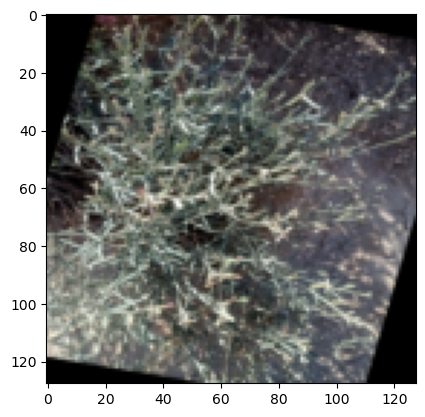

In [220]:
plt.imshow(plantdataset[0][0].permute(1,2,0))

In [233]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define sub-networks as sequential models
        self.image_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*64*64, 128)
        )
        self.date_layer = nn.Sequential(
            nn.Linear(len(date_dict), 8),
            nn.ELU(), 
        )

        # Define the two classifier layers
        self.classifier_species = nn.Linear(128+8, len(species_dict))
        self.classifier_family = nn.Linear(128+8, len(family_dict))
        
        
    def forward(self, x_image, date_vec):
		# Pass the x_image and date_vec through appropriate layers
        x_image = self.image_layer(x_image)
        date_vec = self.date_layer(date_vec)
        # Concatenate x_image and date_vec
        x = torch.cat((x_image, date_vec), dim=1)
        output_species = self.classifier_species(x)
        output_family = self.classifier_family(x)
        return output_species, output_family

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1):
    running_loss = 0.0
    # Iterate over training batches
    for i, (img, date_vec, family_idx, species_idx) in enumerate(plantdatasetLoader):
        optimizer.zero_grad()
        output_species, output_family = model(img, date_vec)
        # Compute species classification loss
        loss_species = criterion(output_species, species_idx)
        # Compute family classification loss
        loss_family = criterion(output_family, family_idx)

        # Compute total loss
        loss = loss_species+loss_family
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1)%100 == 0:
            print(f'Loss after {i+1} batches: {running_loss/(i+1)}')
        
    
    epoch_loss = running_loss / len(AmaranthaceaeLoader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Loss after 100 batches: 12.575538625717163
Loss after 200 batches: 8.97468453168869
Loss after 300 batches: 7.644783306916555
Loss after 400 batches: 6.960564568042755
Loss after 500 batches: 6.495559410095215
Loss after 600 batches: 6.170796649456024
Loss after 700 batches: 5.912651796340942
Loss after 800 batches: 5.721756005883217
Loss after 900 batches: 5.576904505093893


In [ ]:
def evaluate_model(model):
    # Define accuracy metrics
    acc_alpha = Accuracy(task="multiclass", num_classes=30)
    acc_char = Accuracy(task="multiclass", num_classes=964)

    model.eval()
    with torch.no_grad():
        for images, labels_alpha, labels_char in dataloader_test:
            # Obtain model outputs
            outputs_alpha, outputs_char = model(images)
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
			# Update both accuracy metrics
            acc_alpha(pred_alpha, labels_alpha)
            acc_char(pred_char, labels_char)
    
    print(f"Alphabet: {acc_alpha.compute()}")
    print(f"Character: {acc_char.compute()}")

In [ ]:
# Save the model
torch.save(model.state_dict(), 'ModelCNN.pth')

# Create a new model
loaded_model = ManufacturingCNN()

# Load the saved model
loaded_model.load_state_dict(torch.load('ModelCNN.pth'))
print(loaded_model)

## 5. Version_5 implementation

In [201]:
v5_model = load_mobilenet_v2(dataset, num_unfreeze=20)

### Defining the Loss Function and Optimizer.

In [202]:
v5_criterion = nn.CrossEntropyLoss(weight=compute_class_weights(dataset, method="inverse_frequency"))  # Class weighting applied
v5_optimizer = optim.Adamax(v5_model.parameters(), lr=0.02)

### Training & Evaluation

In [203]:
dataset.transform = train_transforms
train_dataset.dataset.transform

Compose(
    RandomApply(
    p=0.8
    RandomRotation(degrees=[-90.0, 90.0], interpolation=bilinear, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    RandomHorizontalFlip(p=0.5)
)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [204]:
v5_train_results, v5_train_accuracy, v5_loss, v5_train_time = train_model(
    v5_model, train_loader, v5_criterion, v5_optimizer, class_names=dataset.classes
)

Epoch 1, Batch 100, Loss: 3.1027, Accuracy: 19.72%, Time Passed: 19.04m
Epoch 1, Batch 200, Loss: 2.5138, Accuracy: 33.09%, Time Passed: 38.36m
Epoch 1, Batch 300, Loss: 2.1033, Accuracy: 41.81%, Time Passed: 57.59m
Epoch 1, Batch 400, Loss: 1.8366, Accuracy: 47.77%, Time Passed: 77.09m
Epoch 1, Batch 500, Loss: 1.6390, Accuracy: 52.63%, Time Passed: 114.77m
Epoch 1 Completed - Average Loss: 1.5669, Accuracy: 54.43%, Epoch Time: 124.13m
Training Complete - Total Time: 124.13m


In [205]:
v5_train_results.to_csv("v5_train_results.csv", index=False)
v5_train_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown     54.716981   0.329545   
1               Anabasis articulata (Forssk.) Moq.     51.666667   0.424658   
2                           Anabasis setifera Moq.     49.529412   0.598011   
3                              Atriplex halimus L.     37.171717   0.606260   
4                               Calotropis procera     79.856115   0.487912   
5                              Capparis spinosa L.     53.392330   0.333948   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     68.205128   0.546201   
7                                 Cenchrus divisus     73.076923   0.562500   
8                     Deverra tortuosa (Desf.) DC.     46.093750   0.181538   
9             Deverra triradiata Hochst. ex Boiss.     53.211009   0.379085   
10               Diplotaxis harra (Forssk.) Boiss.     61.111111   0.373156   
11                        Echinops glaberrimus DC.     62.000000   0.709924   
12                            Ephedra alata Decne.     76.035132   0.661572   
13                         Farsetia aegyptia Turra     37.060041   0.433414   
14                    Gymnocarpos decander Forssk.     42.063492   0.501182   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     51.708767   0.462766   
16                      Heliotropium arborescens L     57.954545   0.582857   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     42.342342   0.198312   
18                   Limonium pruinosum (L.) Chaz.     48.895899   0.454545   
19                   Lycium shawii Roem. & Schult.     52.218115   0.606223   
20                 Nitraria retusa (Forssk.) Asch.     33.906634   0.585987   
21                      Ochradenus baccatus Delile     66.336634   0.793212   
22                              Peganum harmala L.     60.465116   0.509804   
23                             Rumex vesicarius L.     65.294118   0.691589   
24                                      Salsola sp     64.765101   0.457346   
25                        Stachys aegyptiaca Pers.     48.346056   0.448113   
26             Suaeda aegyptiaca (Hasselq.) Zohary     62.461538   0.417695   
27                Tamarix nilotica (Ehrenb.) Bunge     61.793722   0.629799   
28                  Trichodesma africanum (L.) Sm.     42.091837   0.506135   
29                       Zilla spinosa (L.) Prantl     47.379913   0.505828   
30     Zygophyllum arabicum (L.) Christenh. & Byng     51.372119   0.640219   
31                           Zygophyllum coccineum     38.606676   0.549587   
32    Zygophyllum molle (Delile) Christenh. & Byng     67.984190   0.376368   
33                                          others     59.058824   0.585082   
34                     Average Performance (Macro)     54.946234   0.503835   

      Recall  F1-score  
0   0.547170  0.411348  
1   0.516667  0.466165  
2   0.495294  0.541828  
3   0.371717  0.460864  
4   0.798561  0.605730  
5   0.533923  0.410897  
6   0.682051  0.606613  
7   0.730769  0.635688  
8   0.460938  0.260486  
9   0.532110  0.442748  
10  0.611111  0.463370  
11  0.620000  0.661922  
12  0.760351  0.707531  
13  0.370600  0.399554  
14  0.420635  0.457389  
15  0.517088  0.488421  
16  0.579545  0.581197  
17  0.423423  0.270115  
18  0.488959  0.471125  
19  0.522181  0.561072  
20  0.339066  0.429572  
21  0.663366  0.722502  
22  0.604651  0.553191  
23  0.652941  0.671710  
24  0.647651  0.536111  
25  0.483461  0.465116  
26  0.624615  0.500617  
27  0.617937  0.623812  
28  0.420918  0.459610  
29  0.473799  0.489290  
30  0.513721  0.570037  
31  0.386067  0.453538  
32  0.679842  0.484507  
33  0.590588  0.587822  
34  0.549462  0.513279

In [206]:
v5_train_summary = create_performance_summary(v5_train_results, v5_train_accuracy, v5_loss, train_loader,
                                                   model_name='v5_model', train_test='Train', class_weights='inverse_frequency',
                                                   time_taken=v5_train_time)
v5_train_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v5_model        Train         54.434932         54.946234   

   Precision (macro)  Recall (macro)  F1 Score      Loss      Class_weights  \
0           0.503835        0.549462  0.513279  1.566919  inverse_frequency   

           Best_class         Median_class                      Worst_class  \
0  Calotropis procera  Capparis spinosa L.  Nitraria retusa (Forssk.) Asch.   

   Num_classes_above_micro_avg  Num_classes_above_macro_avg  \
0                           16                           15   

   Num_classes_above_macro_median  Time Taken (mins)  
0                              17         124.129859

In [207]:
dataset.transform = test_transforms
test_dataset.dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [208]:
v5_test_results, v5_test_accuracy, v5_test_time = evaluate_model(v5_model, test_loader, class_names=dataset.classes)

Batch 100, Accuracy: 80.44%, Time Passed: 9.97m
Evaluation Complete - Accuracy: 80.80%, Total Time: 13.71m


In [209]:
v5_test_results.to_csv("v5_test_results.csv", index=False)
v5_test_results

Species  Accuracy (%)  Precision  \
0                                    9_2_c unknown    100.000000   0.866667   
1               Anabasis articulata (Forssk.) Moq.     89.333333   0.455782   
2                           Anabasis setifera Moq.     68.544601   0.793478   
3                              Atriplex halimus L.     67.741935   0.870466   
4                               Calotropis procera    100.000000   0.775281   
5                              Capparis spinosa L.     87.058824   0.740000   
6   Cebatha pendula (J.R.Forst. & G.Forst.) Kuntze     93.877551   0.859813   
7                                 Cenchrus divisus     98.275862   0.919355   
8                     Deverra tortuosa (Desf.) DC.     71.875000   0.433962   
9             Deverra triradiata Hochst. ex Boiss.     92.592593   0.694444   
10               Diplotaxis harra (Forssk.) Boiss.     87.378641   0.697674   
11                        Echinops glaberrimus DC.     86.702128   0.953216   
12                            Ephedra alata Decne.     90.954774   0.942708   
13                         Farsetia aegyptia Turra     85.123967   0.639752   
14                    Gymnocarpos decander Forssk.     79.365079   0.826446   
15   Haloxylon salicornicum (Moq.) Bunge ex Boiss.     44.378698   0.949367   
16                      Heliotropium arborescens L     89.204545   0.737089   
17   Iphiona mucronata (Forssk.) Asch. & Schweinf.     89.285714   0.735294   
18                   Limonium pruinosum (L.) Chaz.     87.341772   0.610619   
19                   Lycium shawii Roem. & Schult.     86.715867   0.827465   
20                 Nitraria retusa (Forssk.) Asch.     78.921569   0.690987   
21                      Ochradenus baccatus Delile     76.781003   0.976510   
22                              Peganum harmala L.    100.000000   1.000000   
23                             Rumex vesicarius L.     98.823529   0.954545   
24                                      Salsola sp     94.594595   0.886076   
25                        Stachys aegyptiaca Pers.     87.755102   0.851485   
26             Suaeda aegyptiaca (Hasselq.) Zohary     82.716049   0.848101   
27                Tamarix nilotica (Ehrenb.) Bunge     73.118280   0.898678   
28                  Trichodesma africanum (L.) Sm.     83.673469   0.522293   
29                       Zilla spinosa (L.) Prantl     65.789474   0.773196   
30     Zygophyllum arabicum (L.) Christenh. & Byng     80.701754   0.929293   
31                           Zygophyllum coccineum     80.924855   0.848485   
32    Zygophyllum molle (Delile) Christenh. & Byng     87.301587   0.948276   
33                                          others     83.018868   0.907216   
34                     Average Performance (Macro)     84.407971   0.804824   

      Recall  F1-score  
0   1.000000  0.928571  
1   0.893333  0.603604  
2   0.685446  0.735516  
3   0.677419  0.761905  
4   1.000000  0.873418  
5   0.870588  0.800000  
6   0.938776  0.897561  
7   0.982759  0.950000  
8   0.718750  0.541176  
9   0.925926  0.793651  
10  0.873786  0.775862  
11  0.867021  0.908078  
12  0.909548  0.925831  
13  0.851240  0.730496  
14  0.793651  0.809717  
15  0.443787  0.604839  
16  0.892045  0.807198  
17  0.892857  0.806452  
18  0.873418  0.718750  
19  0.867159  0.846847  
20  0.789216  0.736842  
21  0.767810  0.859675  
22  1.000000  1.000000  
23  0.988235  0.971098  
24  0.945946  0.915033  
25  0.877551  0.864322  
26  0.827160  0.837500  
27  0.731183  0.806324  
28  0.836735  0.643137  
29  0.657895  0.710900  
30  0.807018  0.863850  
31  0.809249  0.828402  
32  0.873016  0.909091  
33  0.830189  0.866995  
34  0.844080  0.812725

In [210]:
v5_test_summary = create_performance_summary(v5_test_results, v5_test_accuracy, None, test_loader,
                                                   model_name='v5_model', train_test='Test', class_weights='inverse_frequency',
                                                   time_taken=v5_test_time)
v5_test_summary

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v5_model         Test          80.80347         84.407971   

   Precision (macro)  Recall (macro)  F1 Score  Loss      Class_weights  \
0           0.804824         0.84408  0.812725  None  inverse_frequency   

      Best_class         Median_class  \
0  9_2_c unknown  Capparis spinosa L.   

                                     Worst_class  Num_classes_above_micro_avg  \
0  Haloxylon salicornicum (Moq.) Bunge ex Boiss.                           24   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           20                              17   

   Time Taken (mins)  
0          13.707717

## Comparative Analysis between Version_1 implementation and Version_5 implementation

**A comparison between Version_1 and Version_5 implementations will be conducted to evaluate the impact of data augmentation. Version_1 does not apply data augmentation, while Version_5 incorporates it. The analysis will focus on key metrics, including accuracy (micro and macro), precision, recall, and F1 score, to assess how data augmentation influences model performance.**

In [212]:
v1_v5_performance = pd.concat([v1_train_summary, v1_test_summary, v5_train_summary, v5_test_summary], ignore_index=True)
v1_v5_performance

/var/folders/r9/013lqpnn2cj0hh05j71mb64h0000gn/T/ipykernel_8672/548161982.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  v1_v5_performance = pd.concat([v1_train_summary, v1_test_summary, v5_train_summary, v5_test_summary], ignore_index=True)


Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v1_model        Train         61.466895         61.599017   
1  v1_model         Test         80.826295         83.259382   
2  v5_model        Train         54.434932         54.946234   
3  v5_model         Test         80.803470         84.407971   

   Precision (macro)  Recall (macro)  F1 Score      Loss      Class_weights  \
0           0.568230        0.615990  0.582349  1.346992  inverse_frequency   
1           0.819656        0.832594  0.810793       NaN  inverse_frequency   
2           0.503835        0.549462  0.513279  1.566919  inverse_frequency   
3           0.804824        0.844080  0.812725       NaN  inverse_frequency   

           Best_class                      Median_class  \
0  Calotropis procera  Tamarix nilotica (Ehrenb.) Bunge   
1    Cenchrus divisus     Lycium shawii Roem. & Schult.   
2  Calotropis procera               Capparis spinosa L.   
3       9_2_c unknown               Capparis spinosa L.   

                                     Worst_class  Num_classes_above_micro_avg  \
0                        Farsetia aegyptia Turra                           17   
1                         Anabasis setifera Moq.                           24   
2                Nitraria retusa (Forssk.) Asch.                           16   
3  Haloxylon salicornicum (Moq.) Bunge ex Boiss.                           24   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           17                              17   
1                           19                              17   
2                           15                              17   
3                           20                              17   

   Time Taken (mins)  
0          54.276279  
1          13.693827  
2         124.129859  
3          13.707717

**Scale up Precision (macro), Recall (macro), and F1 Score.**

In [213]:
v1_v5_performance[['Precision (macro)', 'Recall (macro)', 'F1 Score']] = v1_v5_performance[['Precision (macro)', 'Recall (macro)', 'F1 Score']]*100

In [214]:
v1_v5_performance.to_csv("v1_v5_performance.csv", index=False)

In [215]:
v1_v5_train = v1_v5_performance[v1_v5_performance['Train & Test']=='Train']
v1_v5_train

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
0  v1_model        Train         61.466895         61.599017   
2  v5_model        Train         54.434932         54.946234   

   Precision (macro)  Recall (macro)   F1 Score      Loss      Class_weights  \
0          56.823034       61.599017  58.234921  1.346992  inverse_frequency   
2          50.383456       54.946234  51.327926  1.566919  inverse_frequency   

           Best_class                      Median_class  \
0  Calotropis procera  Tamarix nilotica (Ehrenb.) Bunge   
2  Calotropis procera               Capparis spinosa L.   

                       Worst_class  Num_classes_above_micro_avg  \
0          Farsetia aegyptia Turra                           17   
2  Nitraria retusa (Forssk.) Asch.                           16   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
0                           17                              17   
2                           15                              17   

   Time Taken (mins)  
0          54.276279  
2         124.129859

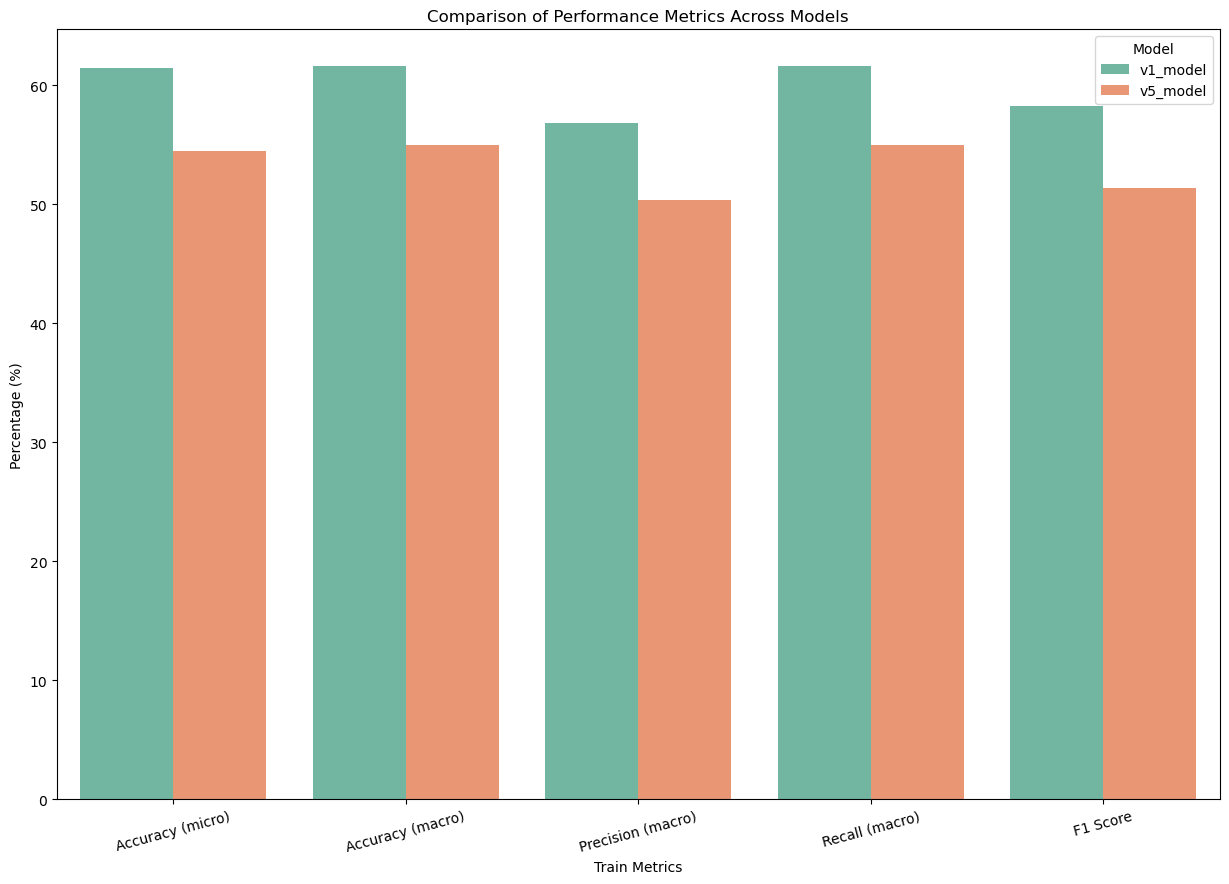

In [216]:
# Define the metrics to compare
metrics = ["Accuracy (micro)", "Accuracy (macro)", "Precision (macro)", "Recall (macro)", "F1 Score"]

# Reshape the dataframe for better visualization (melt operation)
v1_v5_train_results_melted = v1_v5_train.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 10))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=v1_v5_train_results_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Performance Metrics Across Models")
plt.ylabel("Percentage (%)")
plt.xlabel("Train Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

In [217]:
v1_v5_test = v1_v5_performance[v1_v5_performance['Train & Test']=='Test']
v1_v5_test

Model Train & Test  Accuracy (micro)  Accuracy (macro)  \
1  v1_model         Test         80.826295         83.259382   
3  v5_model         Test         80.803470         84.407971   

   Precision (macro)  Recall (macro)   F1 Score  Loss      Class_weights  \
1          81.965625       83.259382  81.079335   NaN  inverse_frequency   
3          80.482421       84.407971  81.272474   NaN  inverse_frequency   

         Best_class                   Median_class  \
1  Cenchrus divisus  Lycium shawii Roem. & Schult.   
3     9_2_c unknown            Capparis spinosa L.   

                                     Worst_class  Num_classes_above_micro_avg  \
1                         Anabasis setifera Moq.                           24   
3  Haloxylon salicornicum (Moq.) Bunge ex Boiss.                           24   

   Num_classes_above_macro_avg  Num_classes_above_macro_median  \
1                           19                              17   
3                           20                              17   

   Time Taken (mins)  
1          13.693827  
3          13.707717

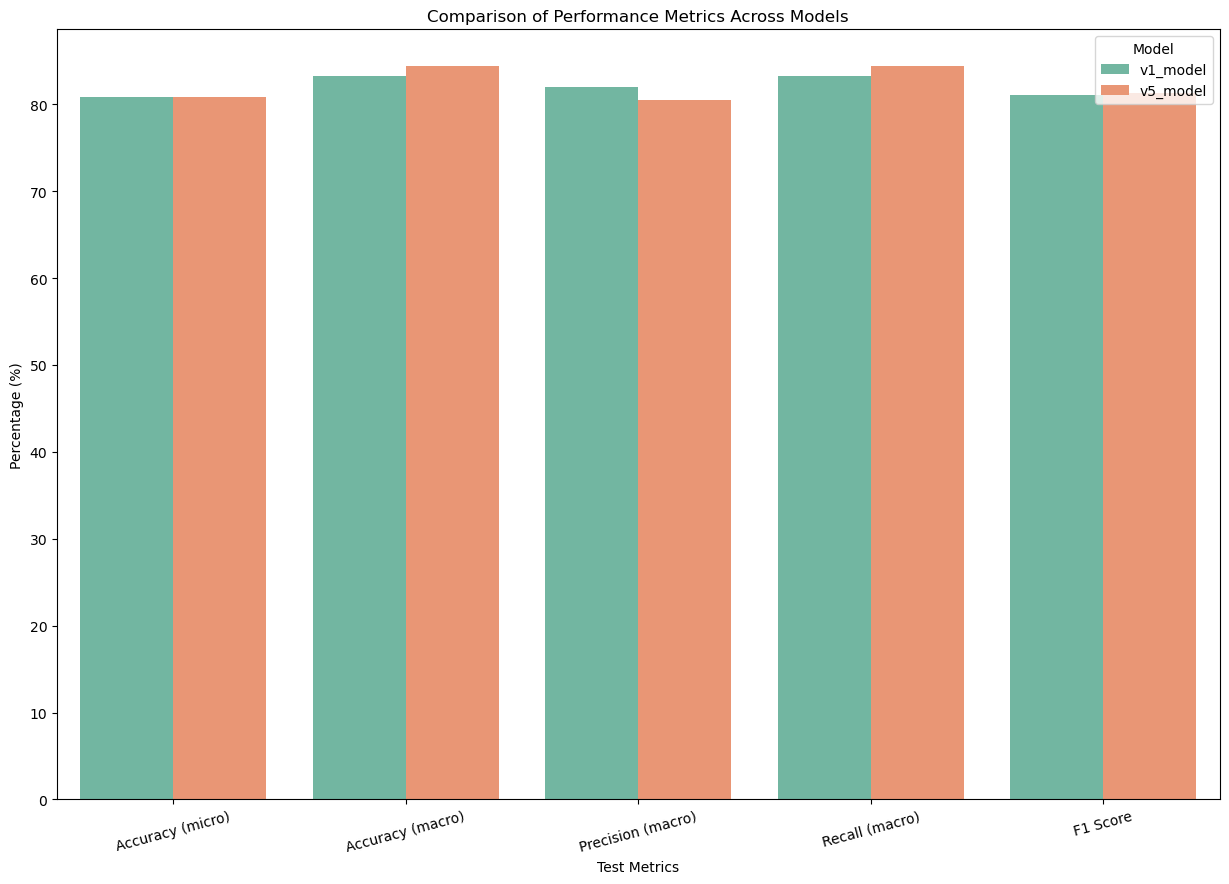

In [218]:
# Define the metrics to compare
metrics = ["Accuracy (micro)", "Accuracy (macro)", "Precision (macro)", "Recall (macro)", "F1 Score"]

# Reshape the dataframe for better visualization (melt operation)
v1_v5_test_results_melted = v1_v5_test.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 10))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=v1_v5_test_results_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Performance Metrics Across Models")
plt.ylabel("Percentage (%)")
plt.xlabel("Test Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

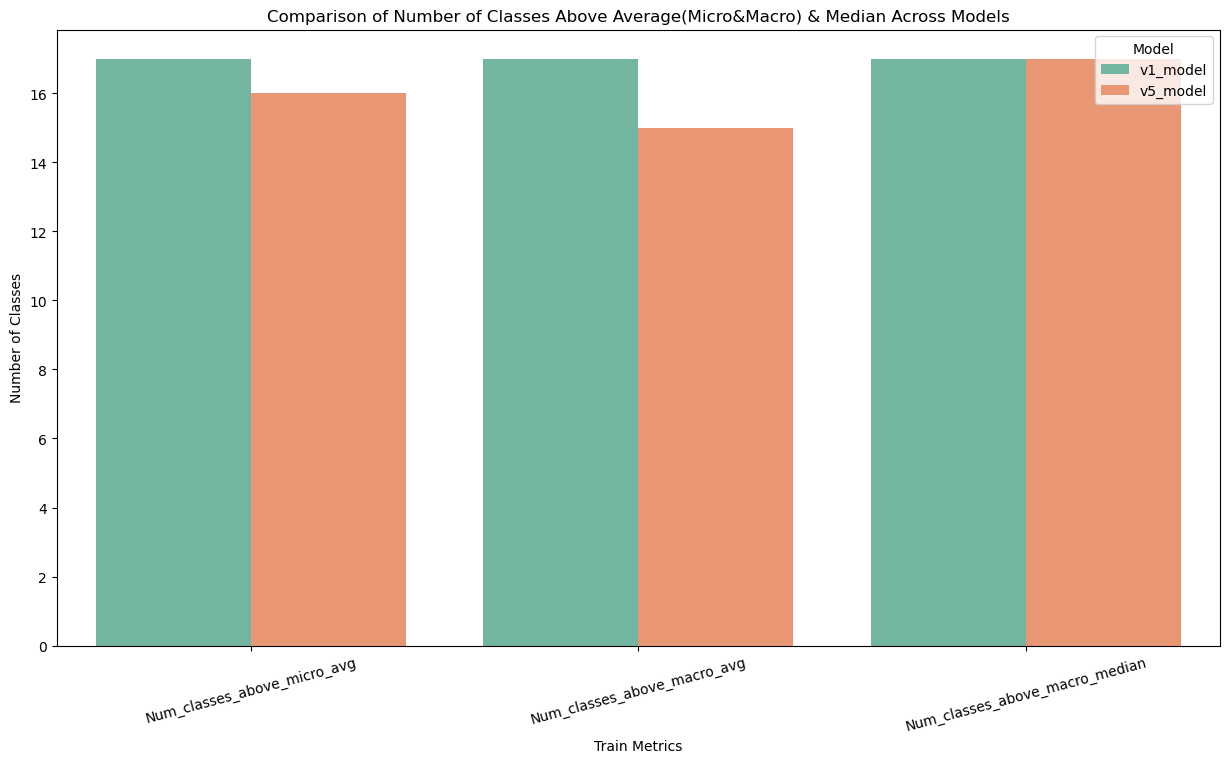

In [222]:
# Define the metrics to compare
class_metrics = [
    "Num_classes_above_micro_avg",
    "Num_classes_above_macro_avg",
    "Num_classes_above_macro_median"
]

# Reshape the dataframe for better visualization
v1_v5_train_class_melted = v1_v5_train.melt(id_vars=["Model"], value_vars=class_metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 8))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=v1_v5_train_class_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Number of Classes Above Average(Micro&Macro) & Median Across Models")
plt.ylabel("Number of Classes")
plt.xlabel("Train Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

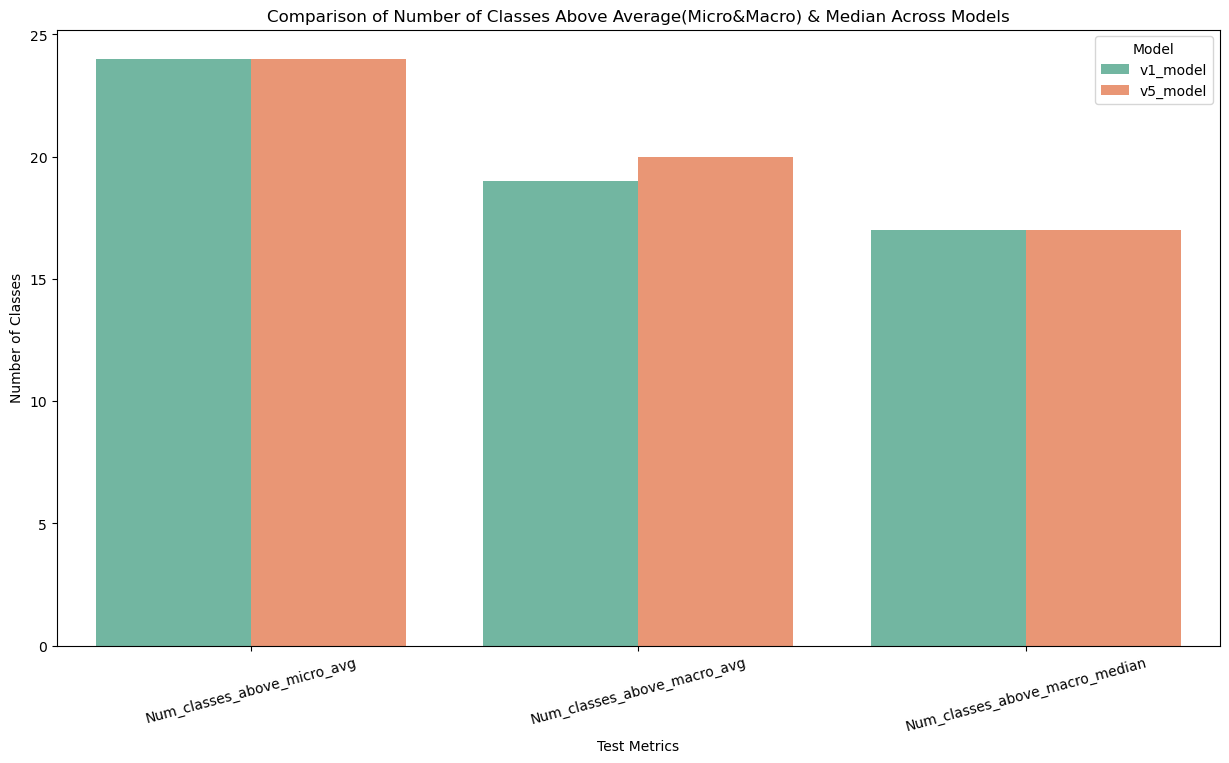

In [223]:
# Define the metrics to compare
class_metrics = [
    "Num_classes_above_micro_avg",
    "Num_classes_above_macro_avg",
    "Num_classes_above_macro_median"
]

# Reshape the dataframe for better visualization
v1_v5_test_class_melted = v1_v5_test.melt(id_vars=["Model"], value_vars=class_metrics, var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(15, 8))

# Create barplot
sns.barplot(x="Metric", y="Value", hue="Model", data=v1_v5_test_class_melted, palette="Set2")

# Title and labels
plt.title("Comparison of Number of Classes Above Average(Micro&Macro) & Median Across Models")
plt.ylabel("Number of Classes")
plt.xlabel("Test Metrics")
plt.xticks(rotation=15)
plt.legend(title="Model")

# Show the plot
plt.show()

- Version_1 outperforms Version_5 in training, which aligns with the purpose of data augmentation—reducing overfitting by encouraging the model to learn general patterns rather than memorizing the training set.
- Despite this, after just one epoch, Version_5 achieves comparable performance to Version_1 and even slightly surpasses it in some aspects (e.g., Num_classes_above_macro_avg: 19 for V1 vs. 20 for V5).
- These results justify continuing training with Version_5, as additional epochs will further enhance its ability to generalize.
- To achieve a balance between overfitting and generalization, Version_5— which incorporates data augmentation—offers a more effective approach.

# <center>Save Models</center>

In [227]:
# Define file paths
default_model_path = "default_model.pth"
v1_model_path = "v1_model.pth"
v2_model_path = "v2_model.pth"
v3_model_path = "v3_model.pth"
v4_model_path = "v4_model.pth"
v5_model_path = "v5_model.pth"

# Save the models
torch.save(default_model.state_dict(), default_model_path)
torch.save(v1_model.state_dict(), v1_model_path)
torch.save(v2_model.state_dict(), v2_model_path)
torch.save(v3_model.state_dict(), v3_model_path)
torch.save(v4_model.state_dict(), v4_model_path)
torch.save(v5_model.state_dict(), v5_model_path)

# Adjusted print statement
print(f"Models saved:\n- {default_model_path}\n- {v1_model_path}\n- {v2_model_path}\n- {v3_model_path}\n- {v4_model_path}\n- {v5_model_path}")

Models saved:
- default_model.pth
- v1_model.pth
- v2_model.pth
- v3_model.pth
- v4_model.pth
- v5_model.pth
